In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import mat73
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
from itertools import chain
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from pygam import LinearGAM
import matplotlib.cm as cm
from scipy.stats import linregress, pearsonr


%load_ext autoreload
%autoreload 2

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from GLM_regression import *
from GLM_regression_plotting import *
plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})


from utils import get_synthetic_data as utils_get_synthetic_data

datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_SST = "SSTindivsomata_GLM"
filepath_SST = os.path.join(datasets_dir, filename_SST+".mat")


datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_NDNF = "NDNFindivsomata_GLM"
filepath_NDNF = os.path.join(datasets_dir, filename_NDNF+".mat")


datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_EC = "EC_GLM"
filepath_EC = os.path.join(datasets_dir, filename_EC+".mat")

activity_dict_SST, factors_dict_SST = preprocess_data(filepath_SST, normalize=True)
activity_dict_NDNF, factors_dict_NDNF = preprocess_data(filepath_NDNF, normalize=True)
activity_dict_EC, factors_dict_EC = preprocess_data(filepath_EC, normalize=True)

filtered_factors_dict_SST = subset_variables_from_data(factors_dict_SST, variables_to_keep=["Velocity"])
filtered_factors_dict_NDNF = subset_variables_from_data(factors_dict_NDNF, variables_to_keep=["Velocity"])
filtered_factors_dict_EC = subset_variables_from_data(factors_dict_EC, variables_to_keep=["Velocity"])


GLM_params_SST, predicted_activity_dict_SST = fit_GLM_population(filtered_factors_dict_SST, activity_dict_SST, quintile=None, regression='ridge', renormalize=True, alphas=None)

GLM_params_NDNF, predicted_activity_dict_NDNF = fit_GLM_population(filtered_factors_dict_NDNF, activity_dict_NDNF, quintile=None, regression='ridge', renormalize=True, alphas=None)
    
GLM_params_EC, predicted_activity_dict_EC = fit_GLM_population(filtered_factors_dict_EC, activity_dict_EC, quintile=None, regression='ridge', renormalize=True, alphas=None)




C:\Users\Msfin\cloned_repositories\CA1-interneuron-GLM\utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
##### velocity plotted over cell trace
 


weight, a, MSE, quintiles_list, mean_quintiles_list, velocity, combined_gaussian_with_velocity, neuron_predicted_activity, residual, divide_data_by_velocity, ramping_field = get_synthetic_data(activity_dict_SST, factors_dict_SST, weight_type="flat", noise_sf=0.0002, ramping_field=True, use_GAM=False, power=1, weight_scale=2, plot=True, field_rotation_factor=25, place_field_sf=-1)


def get_MSE(combined_gaussian_with_velocity, a, residual, divide_data_by_velocity, residuals_squared=False, z_score=False):
    if z_score:
        combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)
        a = (a - np.mean(a)) / np.std(a)
        residual = (residual - np.mean(residual)) / np.std(residual)
        divide_data_by_velocity = (divide_data_by_velocity - np.mean(divide_data_by_velocity)) / np.std(divide_data_by_velocity)
    
    if residuals_squared:
        MSE_activity = np.square(combined_gaussian_with_velocity)
        MSE_residual = np.sqaure(residual)
        MSE_divided = np.square(divide_data_by_velocity)
        
    else:
        MSE_activity = np.mean((a - combined_gaussian_with_velocity) ** 2)
        MSE_residual = np.mean((a - residual) ** 2)
        MSE_divided = np.mean((a - divide_data_by_velocity) ** 2)

    return MSE_activity, MSE_residual, MSE_divided, z_score

MSE_activity, MSE_residual, MSE_divided, z_score =  get_MSE(combined_gaussian_with_velocity, a, residual, divide_data_by_velocity, residuals_squared=False, z_score=False)

plot_synthetic_data(MSE_activity, MSE_residual, MSE_divided, weight, a, quintiles_list, mean_quintiles_list, velocity, combined_gaussian_with_velocity, neuron_predicted_activity, residual, divide_data_by_velocity, ramping_field=ramping_field, z_score=z_score)
  


#flat
#weight="ramping_weight
#weight="step_weight
#### ramping wt still linear just chaning in scale with trial

TypeError: get_synthetic_data() got an unexpected keyword argument 'weight_type'

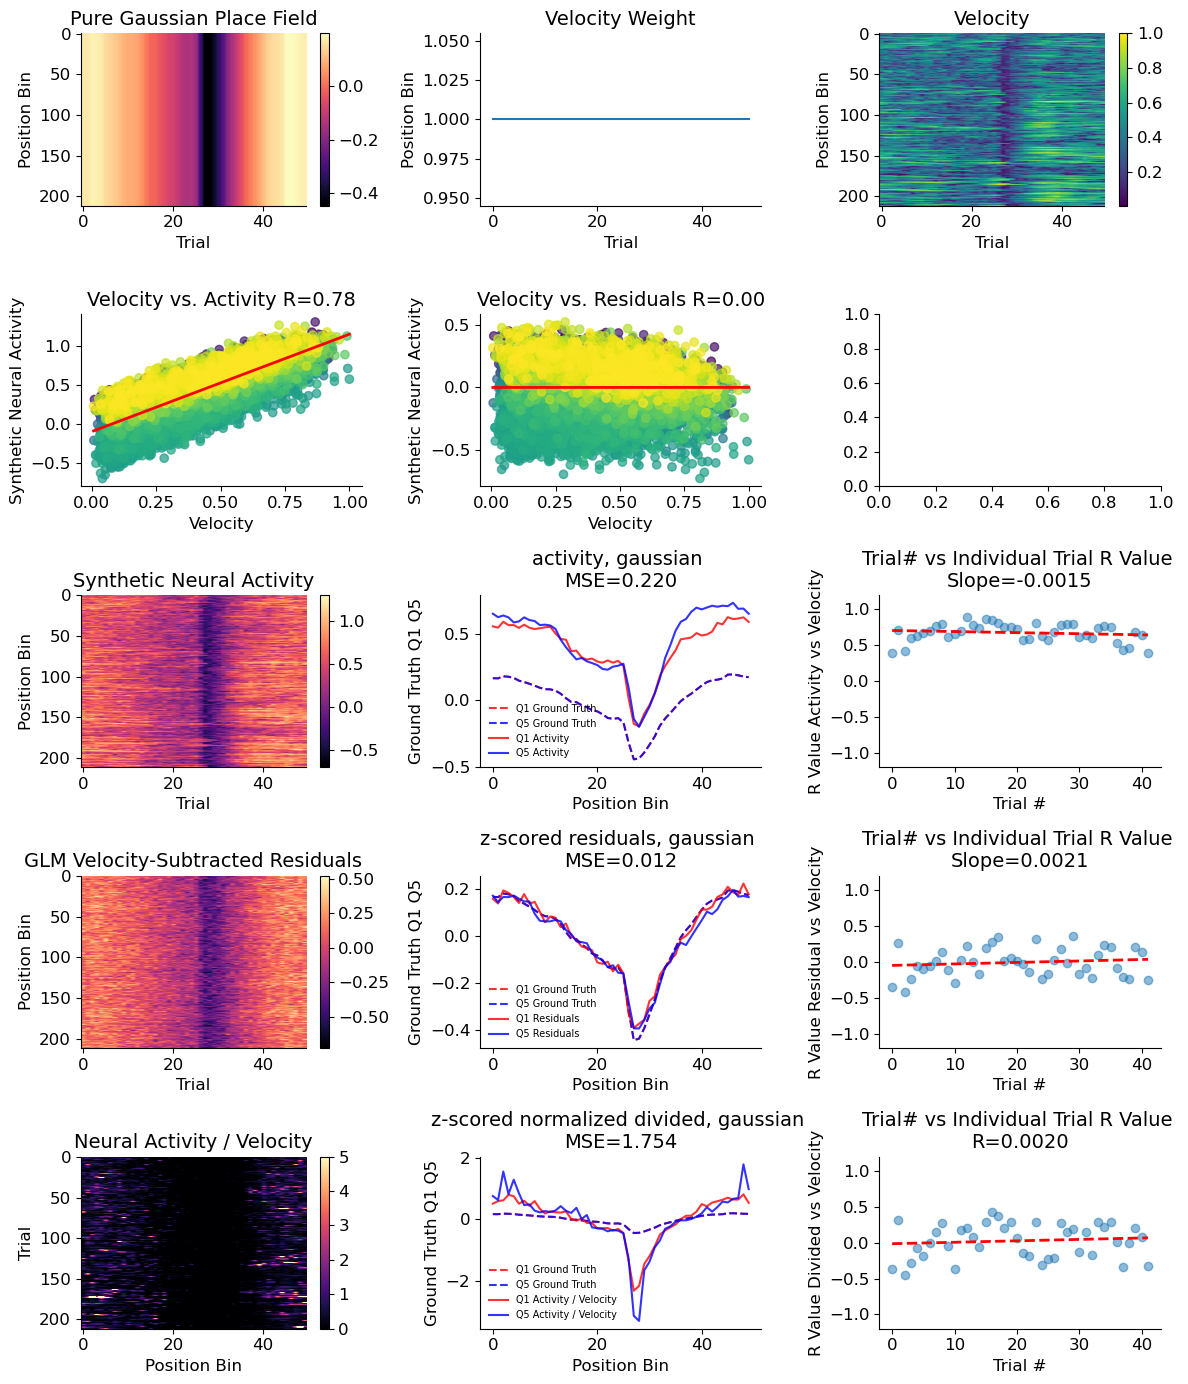

In [3]:

def fit_synthetic_single(combined_activity, velocity, use_GAM=False):
    
    neuron_activity_flat = combined_activity.flatten()
    flattened_data = velocity.flatten().reshape(-1, 1)  

    if use_GAM:
        model = LinearGAM().fit(flattened_data, neuron_activity_flat)
        neuron_predicted_activity = model.predict(flattened_data)
    else:
        alphas = [0.1, 1, 10, 100, 1000, 5000]
        model = RidgeCV(alphas=alphas, cv=None)
        model.fit(flattened_data, neuron_activity_flat)
        neuron_predicted_activity = model.predict(flattened_data)

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)

    residual = combined_activity - neuron_predicted_activity
    
    return residual, combined_activity, neuron_predicted_activity


    
# def get_synthetic_data(activity_dict, factors_dict, velocity_weight_type="ramping_weight", noise_scale=0.1, place_field_type="flat", use_GAM=False, velocity_power=1, velocity_weight=1, place_field_shift=0, place_field_scale=0, z_score=False):
#     velocity = factors_dict["animal_1"]['Velocity']

#     combined_activity, place_field, velocity, noise = utils_get_synthetic_data(activity_dict, velocity, place_field_type=place_field_type, place_field_scale=place_field_scale, place_field_shift=place_field_shift, velocity_weight_type=velocity_weight_type, velocity_weight=velocity_weight, velocity_power=velocity_power, noise_scale=noise_scale)

#     residual, combined_activity, neuron_predicted_activity = fit_synthetic_single(combined_activity, velocity, use_GAM=use_GAM)

#     velocity = np.where(velocity==0, 10e-3, velocity)
    
#     divided_array = residual / velocity

#     MSE_activity, MSE_residual, MSE_divided, z_score = get_MSE(combined_activity, place_field, residual, divided_array, residuals_squared=False, z_score=z_score)

#     return MSE_activity, MSE_residual, MSE_divided, velocity_weight, place_field, velocity, residual, combined_activity, divided_array, neuron_predicted_activity, place_field_type, z_score

    
MSE_activity, MSE_residual, MSE_divided, velocity_weight, place_field, velocity, residual, combined_activity, divided_array, predicted_array, place_field_type, z_score = get_synthetic_data(activity_dict_SST, factors_dict_SST, velocity_weight_type="ramping_weight", noise_scale=0.1, place_field_type="flat", use_GAM=False, velocity_power=1, velocity_weight=1, place_field_shift=0, place_field_scale=0, z_score=False)

plot_synthetic_data_seperate_quintiles(MSE_activity, MSE_residual, MSE_divided, place_field, velocity, residual, combined_activity, divided_array, predicted_array, velocity_weight, place_field_type=place_field_type, z_score=z_score)
        

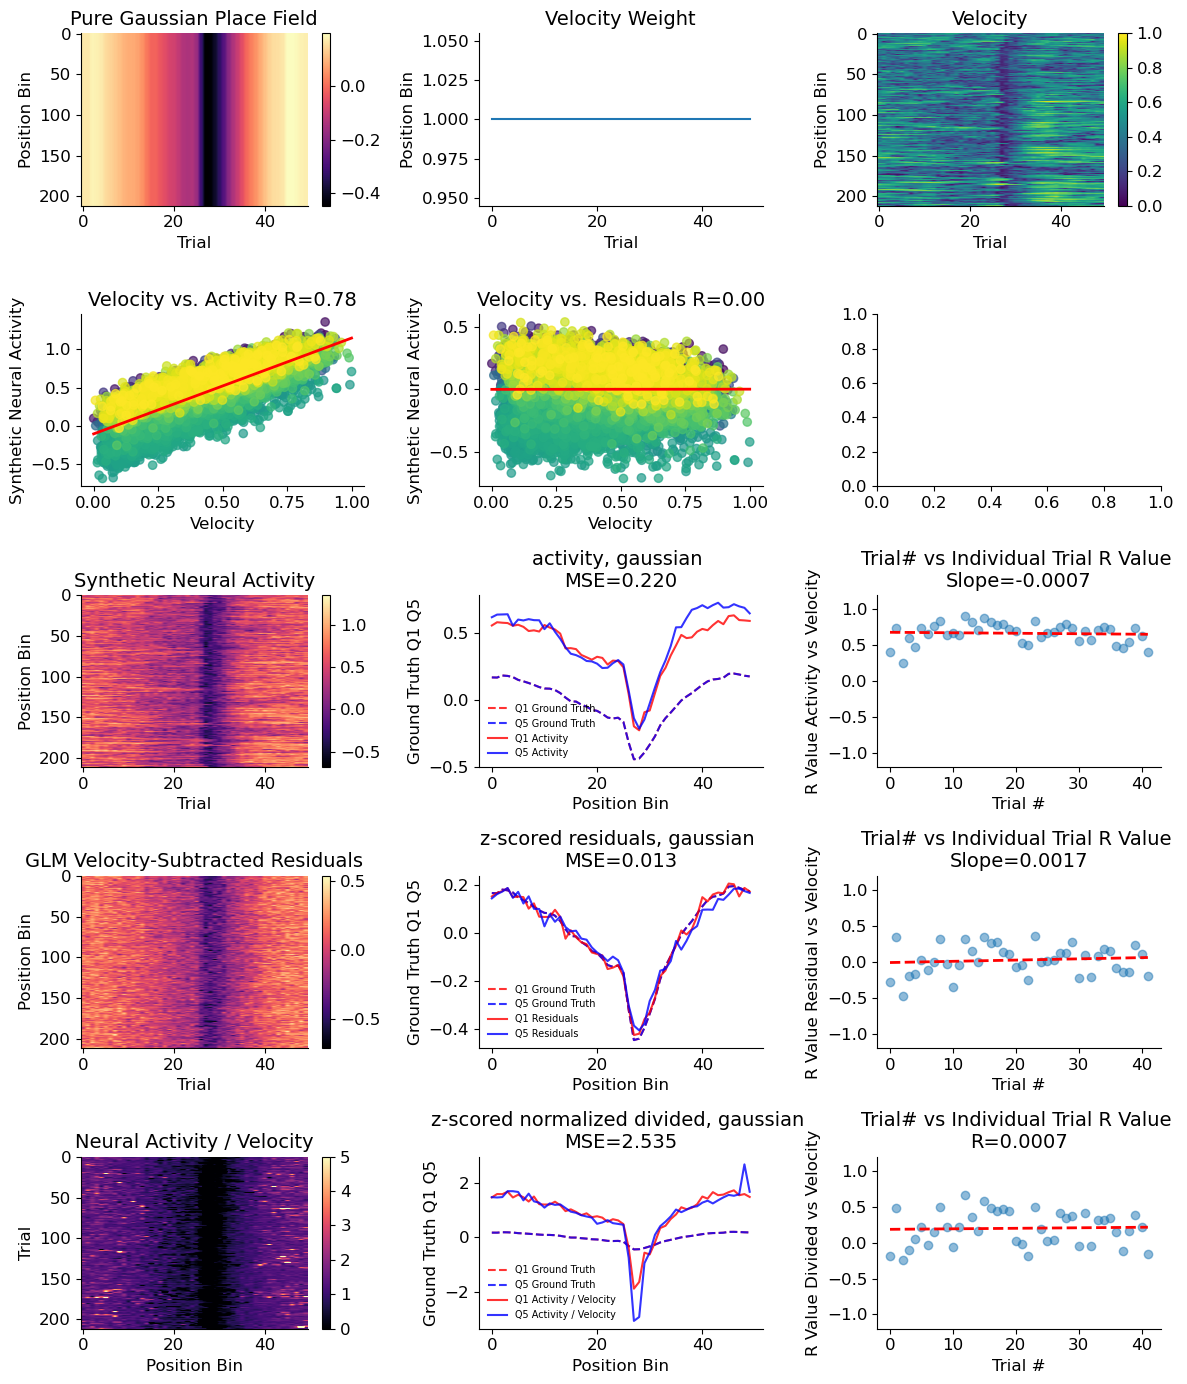

In [5]:
    

# def get_synthetic_data_seperate_quintiles(activity_dict, velocity_weight_type="ramping_weight", noise_scale=0.1, place_field_type="flat", use_GAM=False, velocity_power=1, velocity_weight=1, place_field_shift=0, place_field_scale=0, z_score=False):

    
#     velocity = factors_dict_SST["animal_1"]['Velocity']

    
#     combined_activity, place_field, velocity_component, noise = utils_get_synthetic_data(activity_dict, velocity, place_field_type=place_field_type, place_field_scale=place_field_scale, place_field_shift=place_field_shift, velocity_weight_type=velocity_weight_type, velocity_weight=velocity_weight, velocity_power=velocity_power, noise_scale=noise_scale)
    
    
#     activity_quintiles = get_quintiles_synthetic(combined_activity)
#     velocity_quintiles = get_quintiles_synthetic(velocity)
#     ground_truth_qunitles = get_quintiles_synthetic(place_field)
    
   
#     list_of_mean_data_arrays, list_of_data_arrays = fit_model_to_synthetic_quintiles(activity_quintiles, velocity_quintiles, ground_truth_qunitles, use_GAM=use_GAM)
    
#     residual_array = list_of_data_arrays[0]
#     gaussian_array = list_of_data_arrays[1]
#     divided_array = list_of_data_arrays[2]
#     predicted_array = list_of_data_arrays[4]
    
#     MSE_activity, MSE_residual, MSE_divided, z_score = get_MSE(combined_activity, place_field, residual_array, divided_array, residuals_squared=False, z_score=z_score)

#     return MSE_activity, MSE_residual, MSE_divided, velocity_weight, place_field, velocity, residual_array, gaussian_array, divided_array, predicted_array, place_field_type, z_score
  
    
MSE_activity, MSE_residual, MSE_divided, velocity_weight, place_field, velocity, residual_array, gaussian_array, divided_array, predicted_array, place_field_type, z_score = get_synthetic_data_seperate_quintiles(activity_dict_SST, velocity_weight_type="ramping_weight", noise_scale=0.1, place_field_type="flat", use_GAM=False, velocity_power=1, velocity_weight=1, place_field_shift=0, place_field_scale=0, z_score=False)


    
plot_synthetic_data_seperate_quintiles(MSE_activity, MSE_residual, MSE_divided, place_field, velocity, residual_array, gaussian_array, divided_array, predicted_array, velocity_weight, place_field_type=place_field_type, z_score=z_score)
        
# #flat
# #weight="ramping_weight
# #weight="step_weight
# #### ramping wt still linear just chaning in scale with trial

In [269]:


get_MSE_array_and_plot(activity_dict_SST, factors_dict_SST, cell_type="SST", weight_type="ramping_weight", noise_sf=0., ramping_field=True, use_GAM=False, power=1, weight_scale=10, multimodel=False)



TypeError: get_synthetic_data() got an unexpected keyword argument 'weight_type'

which_MSE=residual


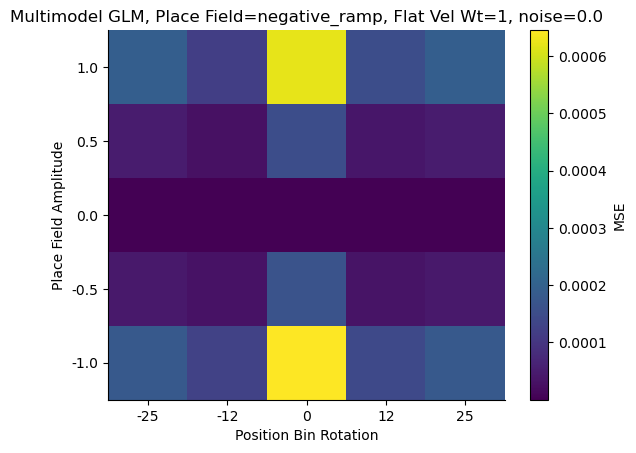

In [55]:
# def get_MSE_array_and_plot(activity_dict_SST, velocity_weight_type="flat", noise_scale=0., place_field_type="flat", use_GAM=True, velocity_power=1, velocity_weight=10, multimodel=False, z_score=False, which_MSE="residual"):

    
#     rotation_array = np.array([-25, -12, 0, 12, 25])
#     pf_amplitude_list = [1.0, 0.5, 0., -0.5, -1.0]

#     y_labels = [str(a) for a in pf_amplitude_list]
#     x_labels = [str(r) for r in rotation_array]

#     overall_modulation_list = []
#     for i in rotation_array:
#         aplitude_list = []
#         for j in pf_amplitude_list:
            
#             if multimodel:
               
#                 MSE_activity, MSE_residual, MSE_divided, velocity_weight, place_field, velocity, residual_array, gaussian_array, divided_array, predicted_array, place_field_type, z_score = get_synthetic_data_seperate_quintiles(activity_dict_SST, velocity_weight_type=velocity_weight_type, noise_scale=noise_scale, place_field_type=place_field_type, use_GAM=use_GAM, velocity_power=velocity_power, velocity_weight=velocity_weight, place_field_shift=i, place_field_scale=j, z_score=z_score)

                
#             else:

#                 MSE_activity, MSE_residual, MSE_divided, velocity_weight, place_field, velocity, residual_array, gaussian_array, divided_array, predicted_array, place_field_type, z_score = get_synthetic_data_seperate_quintiles(activity_dict_SST, velocity_weight_type=velocity_weight_type, noise_scale=noise_scale, place_field_type=place_field_type, use_GAM=use_GAM, velocity_power=velocity_power, velocity_weight=velocity_weight, place_field_shift=i, place_field_scale=j, z_score=z_score)

                
                
#             if which_MSE=="residual":
#                 aplitude_list.append(MSE_residual)
#             elif which_MSE=="activity":
#                 aplitude_list.append(MSE_activity)
#             elif which_MSE=="divided":
#                 aplitude_list.append(MSE_divided)
#             else:
#                 raise ValueError("which_mse takes 'residual', 'activity' ir 'divided'")
            
#         overall_modulation_list.append(aplitude_list)

#     test_array = np.array(overall_modulation_list)
    
#     print(f"which_MSE={which_MSE}")
    
# #     print(f"velocity_weight_type {velocity_weight_type}")
# #     print(f"noise_scale {noise_scale}")
# #     print(f"place_field_type {place_field_type}")
# #     print(f"use_GAM {use_GAM}")
# #     print(f"velocity_weight {velocity_weight}")
# #     print(f"multimodel {multimodel}")
    
    
#     plt.imshow(test_array.T, aspect="auto")
#     plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
#     plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
#     plt.xlabel("Position Bin Rotation")
#     plt.ylabel("Place Field Amplitude")
# #     if ramping_field:
#     if multimodel:
#         if use_GAM:
#             plt.title(f"Multimodel GAM, Place Field={place_field_type}, Flat Vel Wt={velocity_weight}, noise={noise_scale}")
#         else:
#             plt.title(f"Multimodel GLM, Place Field={place_field_type}, Flat Vel Wt={velocity_weight}, noise={noise_scale}")
#     else:
#         if use_GAM:
#             plt.title(f"Single Model GAM, Place Field={place_field_type}, Flat Vel Wt={velocity_weight}, noise={noise_scale}")
#         else:
#             plt.title(f"Single Model GLM, Place Field={place_field_type}, Flat Vel Wt={velocity_weight}, noise={noise_scale}")

#     plt.colorbar(label="MSE")
#     plt.show()

get_MSE_array_and_plot(activity_dict_SST, velocity_weight_type="flat", noise_scale=0., place_field_type="negative_ramp", use_GAM=False, velocity_power=1, velocity_weight=1, multimodel=True, z_score=False, which_MSE="residual")
  
#place field options : "flat", "positive_ramp", "negative_ramp", "step"
    

In [ ]:

def get_average_cell_profile(activity_dict):
    all_cells_average = []
    for animal in activity_dict:
        for neuron in activity_dict[animal]:
            cell_trial_average = activity_dict[animal][neuron].mean(axis=1)
            all_cells_average.append(cell_trial_average)
    all_cells_average = np.stack(all_cells_average, axis=0).mean(axis=0)
    return all_cells_average


def BTSP_field(num_trials):
    BTSP_trial = random.randint(0, num_trials)

    trial_weights = np.zeros(num_trials)

    trial_weights[BTSP_trial:] = 1
    
    return trial_weights


def example_EC_cell(velocity):
    length = 50
    num_trials = velocity.shape[1]
    x = np.linspace(0, length-1, length)

    mean1 = 15   
    std_dev1 = 5  
    original_gaussian1 = norm.pdf(x, mean1, std_dev1)

    mean2 = 35  
    std_dev2 = 5 
    original_gaussian2 = norm.pdf(x, mean2, std_dev2)

    gaussian_list = []

    for i in range(num_trials):
        appear_1 = np.random.choice([0, 1])
        appear_2 = np.random.choice([0, 1])

        gaussian1 = original_gaussian1 * appear_1
        gaussian2 = original_gaussian2 * appear_2

        combined_gaussian = gaussian1 + gaussian2

        bimodal_gaussian = combined_gaussian / np.max(combined_gaussian) if np.max(combined_gaussian) != 0 else combined_gaussian

        gaussian_list.append(bimodal_gaussian)

    pf = np.stack(gaussian_list)
    
    return pf


place_field_profile = get_average_cell_profile(activity_dict)
num_trials = velocity.shape[1]
place_field = np.tile(place_field_profile, (num_trials,1)).T
def staircase_vector(start, stop, num_steps, length):
    steps = np.linspace(start, stop, num_steps)  # Generate step levels
    step_counts = np.full(num_steps, length // num_steps)  # Base count per step
    step_counts[:length % num_steps] += 1  # Distribute remainder among first steps
    return np.repeat(steps, step_counts)  # Repeat steps with adjusted counts
match place_field_type:
    case "flat":
        place_field_scale = np.ones(num_trials)
        place_field *= place_field_scale
    case "positive_ramp":
        place_field_scale = np.linspace(0, place_field_scale, num_trials)
        place_field *= place_field_scale
    case "negative_ramp":
        place_field_scale = np.linspace(place_field_scale, 0, num_trials)
        place_field *= place_field_scale
    case "step":
        place_field_scale = staircase_vector(0, place_field_scale, num_steps=2, length=num_trials)
        place_field *= place_field_scale
    case "BTSP":
        place_field_scale = BTSP_field(num_trials)
        place_field *= place_field_scale
    case "EC":
        place_field = example_EC_cell(velocity)
        
place_field *= place_field_scale
place_field = np.roll(place_field, shift=place_field_shift, axis=0)




    

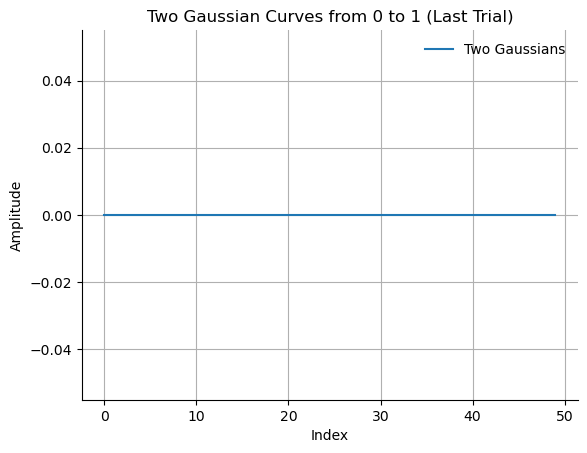

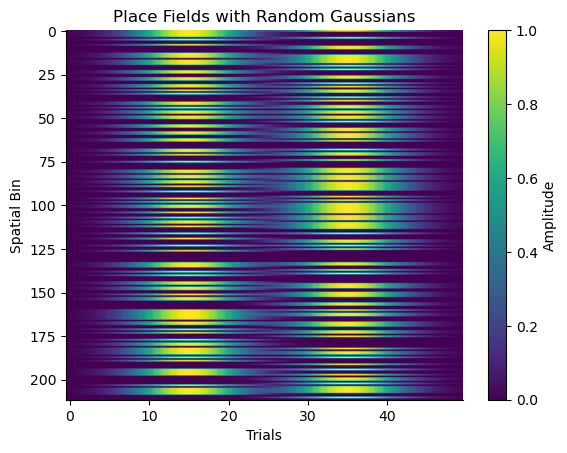

In [70]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt






C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         Current function value: 94.696479
         Iterations: 72
         Function evaluations: 8280
         Gradient evaluations: 156


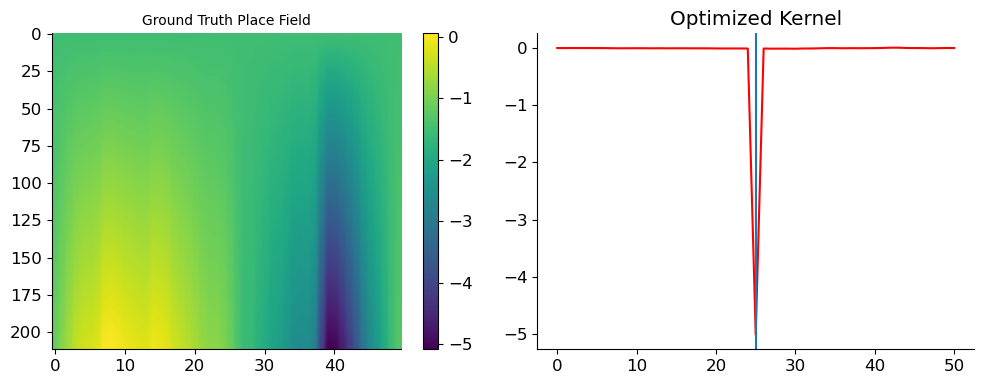

kernel sum -5.471149458687189
weight kernel at center -5.015280221278258
Optimized Bias: 0.19469035920193195
GLM weight [-5.13312203]
GLM intercept 0.0550807157643991


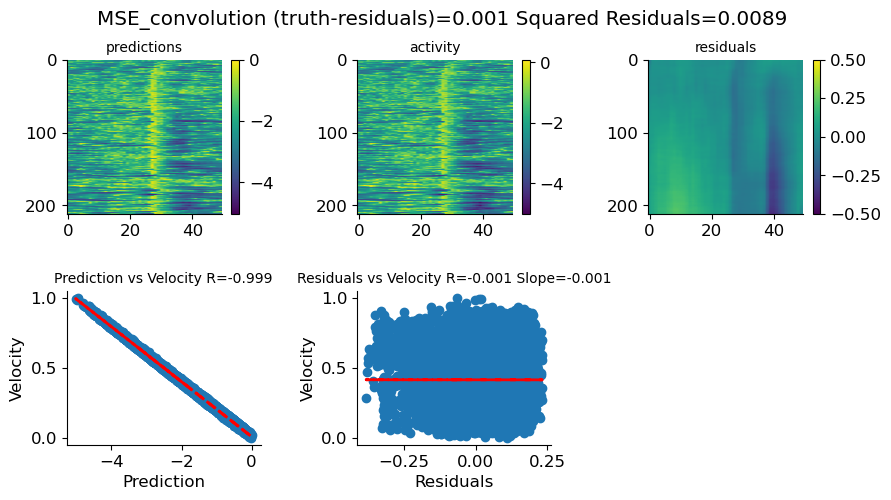

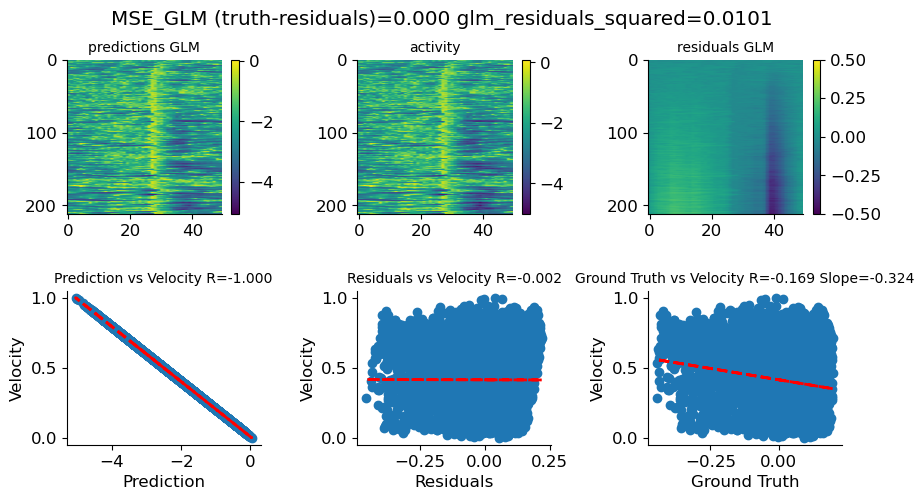

C:\Users\Msfin\AppData\Local\Temp\ipykernel_24236\239260342.py:279: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forced_kernel[25] = kernel_forced_weights


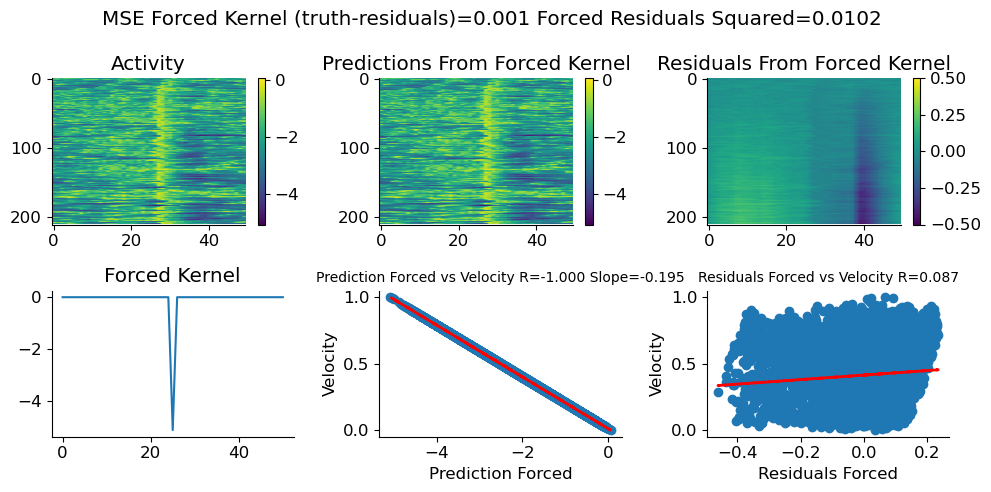

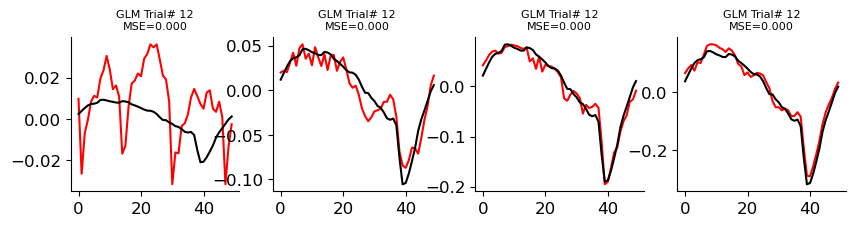

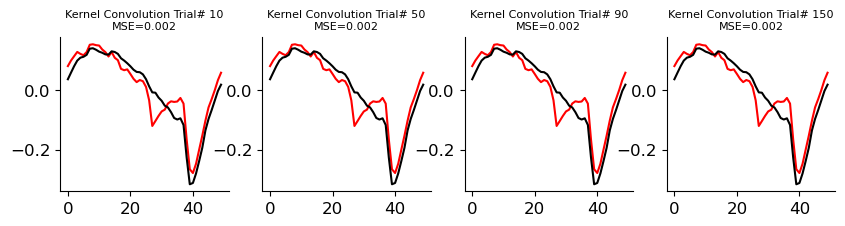

In [175]:
def get_kernel(kernel_length=50, kernel_tau=0.2, center=0.0):
    kernel_t = np.linspace(-1., 1., kernel_length)
    kernel = np.exp(-((kernel_t - center) / kernel_tau)**2.)
    #kernel /= np.sum(kernel)
    return kernel 

cell_number = 12

kernel_length = 51

place_field_sf = 1.0

field_rotation_factor = 12

weight_type = "flat"

weight_scale = -5.0

power = 1.0

noise_sf = 0.0

ramping_field=True

num_trials=212
pf_scale = np.linspace(0, place_field_sf, num_trials)

per_cell_velocity = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

activity_list = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

neurons_array = np.stack(activity_list)
combined_gaussian = np.mean(neurons_array, axis=0)
num_trials = per_cell_velocity[0].shape[1]

velocity = per_cell_velocity[0]
example_cell_velocity = velocity.flatten()

if weight_type=="flat":
    weight = np.ones(num_trials)

elif weight_type=="ramping_weight":
    weight = pf_scale

elif weight_type=="step_weight":
    weight = np.zeros(num_trials)
    quint = len(weight) // 5

    for i in range(5):
        weight[i * quint: (i + 1) * quint] = (i + 1) / 5

weight = weight * weight_scale

velocity_correlation = weight * velocity**(power)

a = np.tile(combined_gaussian, (num_trials, 1)).T

if ramping_field:
    a = a * pf_scale

a = np.roll(a, shift=field_rotation_factor, axis=0)

noise = noise_sf * np.random.normal(0, 1, a.shape)

example_cell_activity = a + velocity_correlation + noise
example_cell_activity = example_cell_activity.flatten()


def blind_deconvolve_error(params, filtered_signal, orig_signal, return_signal=False):    
    kernel = params[:-1] 
    bias = params[-1]  

#     #kernel /= np.sum(kernel)

    guess_filtered_signal = np.convolve(orig_signal, kernel, mode='same')[:len(orig_signal)] + bias

    error = np.sum(np.square(filtered_signal - guess_filtered_signal))
    
    if return_signal:
        return error, guess_filtered_signal
    else:
        return error


init_guess_kernel = np.random.uniform(-1/kernel_length, 1/kernel_length, kernel_length)
init_guess_bias = [0.0] 
initial_guess = np.concatenate([init_guess_kernel, init_guess_bias])

bounds = [(-1, 1)] * kernel_length + [(-5, 5)]

result = minimize(blind_deconvolve_error, x0=initial_guess, args=(example_cell_activity, example_cell_velocity), bounds=bounds, method="BFGS", options={"maxiter": 1000, "eps": 0.0001, "disp": True, "gtol": 1e-8})


final_error, final_guess_filtered_signal = blind_deconvolve_error(result.x, example_cell_activity, example_cell_velocity, return_signal=True)


predictions=final_guess_filtered_signal.reshape(velocity.shape)
activity = example_cell_activity.reshape(velocity.shape)
residuals = activity-predictions
squared_residuals_convolution = np.mean(np.square(residuals))
MSE_convolution = np.mean(np.square(a-residuals))



fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].set_title("Ground Truth Place Field", fontsize=10)
im_1 = axs[0].imshow(a.T, aspect='auto')
fig.colorbar(im1, ax=axs[0])

optimized_kernel = result.x[:-1]
optimized_bias = result.x[-1]

# optimized_kernel /= np.sum(optimized_kernel)


axs[1].plot(optimized_kernel, color='r')
axs[1].axvline(x=25)
# plt.plot(kernel_ground_truth, color='b', label="Kernel Ground Truth")
axs[1].set_title("Optimized Kernel")
axs[1].legend()

plt.tight_layout()
plt.show()

GLM_weight = model.coef_
GLM_intercept = model.intercept_

print(f"kernel sum {np.sum(optimized_kernel)}")
print(f"weight kernel at center {optimized_kernel[25]}")
print(f"Optimized Bias: {optimized_bias}")
print(f"GLM weight {GLM_weight}")
print(f"GLM intercept {GLM_intercept}")


fig, axs = plt.subplots(2, 3, figsize=(10,5))

fig.suptitle(f"MSE_convolution (truth-residuals)={MSE_convolution:.3f} Squared Residuals={squared_residuals_convolution:.4f}")
fig.subplots_adjust(wspace=0.5, hspace=0.5)

plt.plot(final_guess_filtered_signal)
plt.title("final_guess_filtered_signal")

axs[0,0].set_title("predictions", fontsize=10)
im1 = axs[0,0].imshow(predictions.T, aspect='auto')
cbar1 = fig.colorbar(im1, ax=axs[0,0])

axs[0,1].set_title("activity", fontsize=10)
im2 = axs[0,1].imshow(activity.T, aspect='auto')
cbar2 = fig.colorbar(im2, ax=axs[0,1])

axs[0,2].set_title("residuals", fontsize=10)
im3 = axs[0,2].imshow(residuals.T, aspect='auto', vmin=-0.5, vmax=0.5)
cbar3 = fig.colorbar(im3, ax=axs[0,2])


len_activity = len(example_cell_activity)

prediction_velocity_correlation, _ = pearsonr(predictions.flatten(), example_cell_velocity)
slope, intercept, r_value, p_value, std_err = linregress(predictions.flatten(), example_cell_velocity)
trend_line_activity = intercept + slope * predictions.flatten()

axs[1,0].set_title(f"Prediction vs Velocity R={prediction_velocity_correlation:.3f}", fontsize=10)
axs[1,0].scatter(predictions.flatten(), example_cell_velocity)
axs[1,0].set_ylabel("Velocity")
axs[1,0].set_xlabel("Prediction")
axs[1,0].plot(predictions.flatten(), trend_line_activity, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")

flat_residuals = residuals.flatten()

residuals_velocity_correlation, _ = pearsonr(flat_residuals, example_cell_velocity)
slope, intercept, r_value, p_value, std_err = linregress(flat_residuals, example_cell_velocity)
trend_line_residuals = intercept + slope * flat_residuals

axs[1,1].set_title(f"Residuals vs Velocity R={residuals_velocity_correlation:.3f} Slope={slope:.3f}", fontsize=10)
axs[1,1].scatter(flat_residuals, example_cell_velocity)
axs[1,1].set_ylabel("Velocity")
axs[1,1].set_xlabel("Residuals")
axs[1,1].plot(flat_residuals, trend_line_residuals, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")

fig.delaxes(axs[1, 2])

plt.tight_layout
plt.show()


################################# GLM prediction 



alphas=None

model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

model.fit(example_cell_velocity.reshape(-1, 1), example_cell_activity)

neuron_predicted_activity = model.predict(example_cell_velocity.reshape(-1, 1))

neuron_predicted_activity = neuron_predicted_activity.reshape(predictions.shape)

residuals_GLM = activity - neuron_predicted_activity

MSE_GLM = np.mean(np.square(a-residuals_GLM))
glm_residuals_squared = np.mean(np.square(residuals_GLM))


fig, axs = plt.subplots(2, 3, figsize=(10,5))

fig.suptitle(f"MSE_GLM (truth-residuals)={MSE_GLM:.3f} glm_residuals_squared={glm_residuals_squared:.4f}")
fig.subplots_adjust(wspace=0.5, hspace=0.5)

axs[0, 0].set_title("predictions GLM", fontsize=10)
im1 = axs[0, 0].imshow(neuron_predicted_activity.T, aspect='auto')
cbar1 = fig.colorbar(im1, ax=axs[0, 0])

axs[0, 1].set_title("activity", fontsize=10)
im2 = axs[0, 1].imshow(activity.T, aspect='auto')
cbar2 = fig.colorbar(im2, ax=axs[0, 1])

axs[0, 2].set_title("residuals GLM", fontsize=10)
im3 = axs[0, 2].imshow(residuals_GLM.T, aspect='auto', vmin=-0.5, vmax=0.5)
cbar2 = fig.colorbar(im3, ax=axs[0, 2])



len_activity = len(example_cell_activity)

prediction_velocity_correlation, _ = pearsonr(neuron_predicted_activity.flatten(), example_cell_velocity)
slope, intercept, r_value, p_value, std_err = linregress(neuron_predicted_activity.flatten(), example_cell_velocity)
trend_line_activity = intercept + slope * neuron_predicted_activity.flatten()

axs[1,0].set_title(f"Prediction vs Velocity R={prediction_velocity_correlation:.3f}", fontsize=10)
axs[1,0].scatter(neuron_predicted_activity.flatten(), example_cell_velocity)
axs[1,0].set_ylabel("Velocity")
axs[1,0].set_xlabel("Prediction")
axs[1,0].plot(neuron_predicted_activity.flatten(), trend_line_activity, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")

flat_residuals = residuals_GLM.flatten()

residuals_velocity_correlation, _ = pearsonr(flat_residuals, example_cell_velocity)
slope, intercept, r_value, p_value, std_err = linregress(flat_residuals, example_cell_velocity)
trend_line_residuals = intercept + slope * flat_residuals

axs[1,1].set_title(f"Residuals vs Velocity R={residuals_velocity_correlation:.3f}", fontsize=10)
axs[1,1].scatter(flat_residuals, example_cell_velocity)
axs[1,1].set_ylabel("Velocity")
axs[1,1].set_xlabel("Residuals")
axs[1,1].plot(flat_residuals, trend_line_residuals, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")

flat_ground_truth = a.flatten()
truth_velocity_correlation, _ = pearsonr(flat_ground_truth, example_cell_velocity)
slope, intercept, r_value, p_value, std_err = linregress(flat_ground_truth, example_cell_velocity)
trend_line_truth = intercept + slope * flat_ground_truth

axs[1,2].set_title(f"Ground Truth vs Velocity R={truth_velocity_correlation:.3f} Slope={slope:.3f}", fontsize=10)
axs[1,2].scatter(flat_ground_truth, example_cell_velocity)
axs[1,2].set_ylabel("Velocity")
axs[1,2].set_xlabel("Ground Truth")
axs[1,2].plot(flat_ground_truth, trend_line_truth, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")


plt.tight_layout
plt.show()





kernel_forced_weights = GLM_weight
kernel_forced_intercept = GLM_intercept

forced_kernel = np.zeros(51)
forced_kernel[25] = kernel_forced_weights

new_prediction = np.convolve(example_cell_velocity, forced_kernel, mode="same") + kernel_forced_intercept

new_residual = example_cell_activity - new_prediction

new_residual = new_residual.reshape(per_cell_velocity[0].shape)

MSE_forced = np.mean(np.square(a-new_residual))

residual_squared_forced = np.mean(np.square(new_residual))



fig, axs = plt.subplots(2, 3, figsize=(10,5))
fig.suptitle(f"MSE Forced Kernel (truth-residuals)={MSE_forced:.3f} Forced Residuals Squared={residual_squared_forced:.4f}")

new_prediction = new_prediction.reshape(velocity.shape)
im0 = axs[0, 0].imshow(new_prediction.T, aspect='auto')
axs[0, 0].set_title("Activity")
fig.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(new_prediction.T, aspect='auto')
axs[0, 1].set_title("Predictions From Forced Kernel")
plt.colorbar(im1, ax=axs[0, 1])

im2 = axs[0, 2].imshow(new_residual.T, aspect='auto', vmin=-0.5, vmax=0.5)
axs[0, 2].set_title("Residuals From Forced Kernel")
plt.colorbar(im2, ax=axs[0, 2])

axs[1, 0].plot(forced_kernel)
axs[1, 0].set_title("Forced Kernel")

forced_flattened_prediction = new_prediction.flatten()

pred_velocity_correlation, _ = pearsonr(forced_flattened_prediction, example_cell_velocity)
slope, intercept, r_value, p_value, std_err = linregress(forced_flattened_prediction, example_cell_velocity)
trend_line_pred = intercept + slope * forced_flattened_prediction

axs[1,1].set_title(f"Prediction Forced vs Velocity R={pred_velocity_correlation:.3f} Slope={slope:.3f}", fontsize=10)
axs[1,1].scatter(forced_flattened_prediction, example_cell_velocity)
axs[1,1].set_ylabel("Velocity")
axs[1,1].set_xlabel("Prediction Forced")
axs[1,1].plot(new_prediction.flatten(), trend_line_pred, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")


flat_residuals_forced = new_residual.flatten()

residuals_velocity_correlation, _ = pearsonr(flat_residuals_forced, example_cell_velocity)
slope, intercept, r_value, p_value, std_err = linregress(flat_residuals_forced, example_cell_velocity)
trend_line_residuals = intercept + slope * flat_residuals_forced

axs[1,2].set_title(f"Residuals Forced vs Velocity R={residuals_velocity_correlation:.3f}", fontsize=10)
axs[1,2].scatter(flat_residuals_forced, example_cell_velocity)
axs[1,2].set_ylabel("Velocity")
axs[1,2].set_xlabel("Residuals Forced")
axs[1,2].plot(flat_residuals_forced, trend_line_residuals, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")

plt.tight_layout()
plt.show()



example_cell_list = [10, 50, 90, 150]

fig, axs = plt.subplots(1, 4, figsize=(10,2))

for idx, trial_number in enumerate(example_cell_list):
    residual_slice_GLM = residuals_GLM[:, trial_number]
    ground_truth_slice = a[:, trial_number]
    error = np.mean(np.square(ground_truth_slice - residual_slice_GLM))
    
    axs[idx].plot(residual_slice_GLM, label="Residuals GLM", color='r')
    axs[idx].plot(ground_truth_slice, label="Ground Truth", color='k')
    axs[idx].set_title(f"GLM Trial# {cell_number}\nMSE={error:.3f}", fontsize=8)
    
fig, axs = plt.subplots(1, 4, figsize=(10,2))

for idx, cell_number in enumerate(example_cell_list):
    residual_slice_kernel = residuals[:, trial_number]
    error = np.mean(np.square(ground_truth_slice - residual_slice_kernel))
    
    axs[idx].plot(residual_slice_kernel, label="Residuals Kernel", color='r')
    axs[idx].plot(ground_truth_slice, label="Ground Truth", color='k')
    axs[idx].set_title(f"Kernel Convolution Trial# {cell_number}\nMSE={error:.3f}", fontsize=8)
    
plt.show()

    






In [86]:
print(factors_dict_SST['animal_1'].keys())

dict_keys(['Licks', 'Reward_loc', 'Velocity', 'Position_1', 'Position_2', 'Position_3', 'Position_4', 'Position_5', 'Position_6', 'Position_7', 'Position_8', 'Position_9', 'Position_10'])


array_zero.shape (50, 212)
75


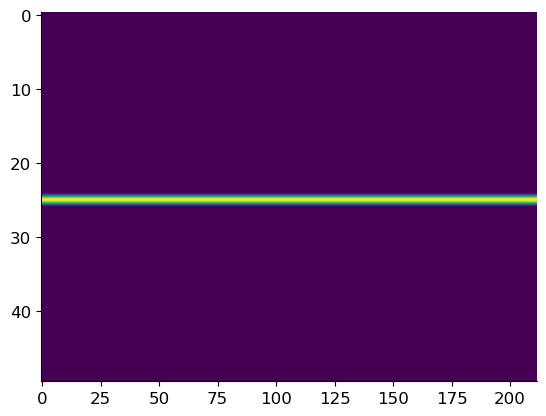

In [123]:
per_cell_velocity = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

activity_list = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(activity_dict_SST[animal][neuron])
        
        
#### do we really want to renormalize 

def fit_kernels_population(factors_dict_SST, activity_dict_SST, quintile=None):  #renormalize=True
    predicted_activity_dict = {}
    residuals_dict = {}
    optimized_kernel_dict = {}
    optimized_bias_dict = {}
    MSE_convolution_dict = {}
    
    for animal in factors_dict_SST:
        predicted_activity_dict[animal] = {}
        residuals_dict[animal] = {}
        optimized_kernel_dict[animal] = {}
        optimized_bias_dict[animal] = {}
        MSE_convolution_dict[animal] = {}
        animal_velocity = factors_dict_SST[animal]['Velocity'].copy()
        
        if quintile is not None:
            num_trials = animal_velocity.shape[1]
            start_idx, end_idx = get_quintile_indices(num_trials, quintile)
            animal_velocity = animal_velocity[:, start_idx:end_idx]
            
#         if renormalize:
#            # neuron_dict[var_name] = (neuron_dict[var_name] - np.mean(neuron_dict[var_name])) / np.std(neuron_dict[var_name])
#             animal_velocity = (animal_velocity - np.min(animal_velocity)) / (np.max(animal_velocity) - np.min(animal_velocity))
            
        for neuron_idx in activity_dict_SST[animal]:
            neuron_activity = activity_dict_SST[animal][neuron_idx]

            neuron_predicted_activity, neuron_residual, optimized_kernel, optimized_bias, MSE_convolution = fit_kernel(animal_velocity, neuron_activity)
            
            predicted_activity_dict[animal][neuron_idx] = neuron_predicted_activity
            residuals_dict[animal][neuron_idx] = neuron_residual
            optimized_kernel_dict[animal][neuron_idx] = optimized_kernel
            optimized_bias_dict[animal][neuron_idx] = optimized_bias
            MSE_convolution_dict[animal][neuron_idx] = MSE_convolution 
            
    return predicted_activity_dict, residuals_dict, optimized_kernel_dict, optimized_bias_dict, MSE_convolution_dict 
        

def fit_kernel(animal_velocity, neuron_activity):
    
    animal_velocity_flat = animal_velocity.flatten()
    neuron_activity_flat = neuron_activity.flatten()
    
    def blind_deconvolve_error(params, filtered_signal, orig_signal, return_signal=False):    
        kernel = params[:-1] 
        bias = params[-1]  

    #     #kernel /= np.sum(kernel)

        guess_filtered_signal = np.convolve(orig_signal, kernel, mode='same')[:len(orig_signal)] + bias

        error = np.sum(np.square(filtered_signal - guess_filtered_signal))

        if return_signal:
            return error, guess_filtered_signal
        else:
            return error


    init_guess_kernel = np.random.uniform(-1/kernel_length, 1/kernel_length, kernel_length)
    init_guess_bias = [0.0] 
    initial_guess = np.concatenate([init_guess_kernel, init_guess_bias])

    bounds = [(-1, 1)] * kernel_length + [(-5, 5)]

    result = minimize(blind_deconvolve_error, x0=initial_guess, args=(example_cell_activity, example_cell_velocity), bounds=bounds, method="BFGS", options={"maxiter": 1000000, "eps": 0.01, "disp": True})

    final_error, final_guess_filtered_signal = blind_deconvolve_error(result.x, neuron_activity_flat, animal_velocity_flat, return_signal=True)

    neuron_predicted_activity=final_guess_filtered_signal.reshape(animal_velocity.shape)
    neuron_residual = neuron_activity - neuron_predicted_activity
    MSE_convolution = np.mean(np.square(residuals))
    
    optimized_kernel = result.x[:-1]
    optimized_bias = result.x[-1]

    return neuron_predicted_activity, neuron_residual, optimized_kernel, optimized_bias, MSE_convolution




predicted_activity_dict, residuals_dict, optimized_kernel_dict, optimized_bias_dict, MSE_convolution_dict = fit_kernels_population(factors_dict_SST, activity_dict_SST, quintile=None)
   



C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.228768
         Iterations: 74
         Function evaluations: 9287
         Gradient evaluations: 175
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 72
         Function evaluations: 7102
         Gradient evaluations: 134
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 7102
         Gradient evaluations: 134


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.839341
         Iterations: 55
         Function evaluations: 8280
         Gradient evaluations: 156
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6996
         Gradient evaluations: 132


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230199
         Iterations: 72
         Function evaluations: 8333
         Gradient evaluations: 157


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.586203
         Iterations: 55
         Function evaluations: 7750
         Gradient evaluations: 146
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6890
         Gradient evaluations: 130


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.229520
         Iterations: 74
         Function evaluations: 9711
         Gradient evaluations: 183
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 7473
         Gradient evaluations: 141
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6466
         Gradient evaluations: 122


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230212
         Iterations: 72
         Function evaluations: 9605
         Gradient evaluations: 181


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.226076
         Iterations: 75
         Function evaluations: 9340
         Gradient evaluations: 176
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6572
         Gradient evaluations: 124


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230220
         Iterations: 72
         Function evaluations: 8545
         Gradient evaluations: 161


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.210300
         Iterations: 75
         Function evaluations: 9022
         Gradient evaluations: 170
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 7208
         Gradient evaluations: 136


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.229317
         Iterations: 72
         Function evaluations: 9446
         Gradient evaluations: 178


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230213
         Iterations: 72
         Function evaluations: 8386
         Gradient evaluations: 158


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.215909
         Iterations: 73
         Function evaluations: 9446
         Gradient evaluations: 178


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230218
         Iterations: 72
         Function evaluations: 8492
         Gradient evaluations: 160


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 101.733022
         Iterations: 34
         Function evaluations: 5364
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 7102
         Gradient evaluations: 134
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6678
         Gradient evaluations: 126


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 72.597001
         Iterations: 55
         Function evaluations: 8015
         Gradient evaluations: 151
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 7261
         Gradient evaluations: 137
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6890
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6837
         Gradient evaluations: 129


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.222841
         Iterations: 75
         Function evaluations: 8862
         Gradient evaluations: 167


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.958567
         Iterations: 52
         Function evaluations: 7538
         Gradient evaluations: 142


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.195363
         Iterations: 73
         Function evaluations: 9446
         Gradient evaluations: 178


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 72.102264
         Iterations: 52
         Function evaluations: 7167
         Gradient evaluations: 135


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.211702
         Iterations: 75
         Function evaluations: 9393
         Gradient evaluations: 177


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230128
         Iterations: 72
         Function evaluations: 9711
         Gradient evaluations: 183
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6943
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6625
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6784
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6943
         Gradient evaluations: 131


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.227535
         Iterations: 76
         Function evaluations: 10135
         Gradient evaluations: 191
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6784
         Gradient evaluations: 128


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 114.548932
         Iterations: 34
         Function evaluations: 5258
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 7261
         Gradient evaluations: 137


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.205395
         Iterations: 75
         Function evaluations: 9446
         Gradient evaluations: 178
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6996
         Gradient evaluations: 132
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 7314
         Gradient evaluations: 138


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.228548
         Iterations: 71
         Function evaluations: 8651
         Gradient evaluations: 163


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.223383
         Iterations: 72
         Function evaluations: 9181
         Gradient evaluations: 173


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 72.998388
         Iterations: 55
         Function evaluations: 8174
         Gradient evaluations: 154


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230156
         Iterations: 72
         Function evaluations: 8121
         Gradient evaluations: 153
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 7208
         Gradient evaluations: 136
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6625
         Gradient evaluations: 125


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.218525
         Iterations: 72
         Function evaluations: 9234
         Gradient evaluations: 174


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 73.076741
         Iterations: 55
         Function evaluations: 7220
         Gradient evaluations: 136
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6784
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 7420
         Gradient evaluations: 140
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6837
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6731
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6837
         Gradient

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 72.804834
         Iterations: 55
         Function evaluations: 7962
         Gradient evaluations: 150
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6996
         Gradient evaluations: 132


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 72.714764
         Iterations: 55
         Function evaluations: 7803
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6996
         Gradient evaluations: 132
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6678
         Gradient evaluations: 126
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 6996
         Gradient evaluations: 132


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.227146
         Iterations: 75
         Function evaluations: 9340
         Gradient evaluations: 176


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.227157
         Iterations: 74
         Function evaluations: 9393
         Gradient evaluations: 177
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6784
         Gradient evaluations: 128


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230219
         Iterations: 72
         Function evaluations: 8810
         Gradient evaluations: 166


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.223633
         Iterations: 71
         Function evaluations: 9287
         Gradient evaluations: 175
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 7049
         Gradient evaluations: 133


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.230219
         Iterations: 72
         Function evaluations: 9340
         Gradient evaluations: 176


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


         Current function value: 71.207583
         Iterations: 74
         Function evaluations: 9340
         Gradient evaluations: 176
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 74
         Function evaluations: 7473
         Gradient evaluations: 141
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 75
         Function evaluations: 6784
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 71.230221
         Iterations: 73
         Function evaluations: 6731
         Gradient evaluations: 127


(50, 212)
(50, 212)
(51,)


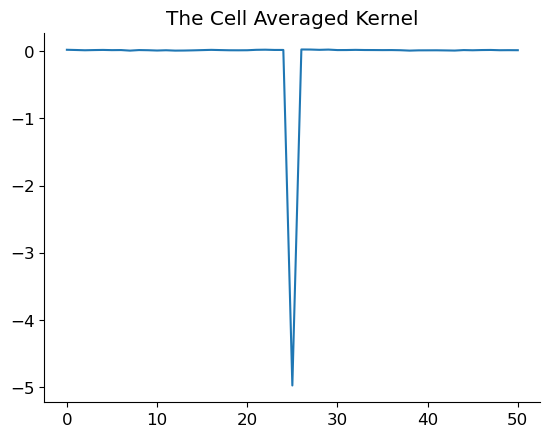

In [110]:
predicted_activity_list = []
residuals_list = []
optimized_kernel_list = []
optimized_bias_list = []
MSE_convolution_list = []

for animal in activity_dict_SST:
    for neuron_idx in activity_dict_SST[animal]:
        predicted_activity_list.append(predicted_activity_dict[animal][neuron_idx])
        residuals_list.append(residuals_dict[animal][neuron_idx])
        optimized_kernel_list.append(optimized_kernel_dict[animal][neuron_idx])
        optimized_bias_list.append(optimized_bias_dict[animal][neuron_idx])
        MSE_convolution_list.append(MSE_convolution_dict[animal][neuron_idx])


        
print(predicted_activity_list[1].shape)
print(residuals_list[1].shape)
print(optimized_kernel_list[1].shape)
# print(len(optimized_bias_list[1]))
# print(len(MSE_convolution_list[1]))



################ the average kernel 

kernel_2d = np.stack(optimized_kernel_list)
average_kernel = np.mean(kernel_2d, axis=0)

plt.figure()
plt.plot(average_kernel)
plt.title("The Cell Averaged Kernel")
plt.show()

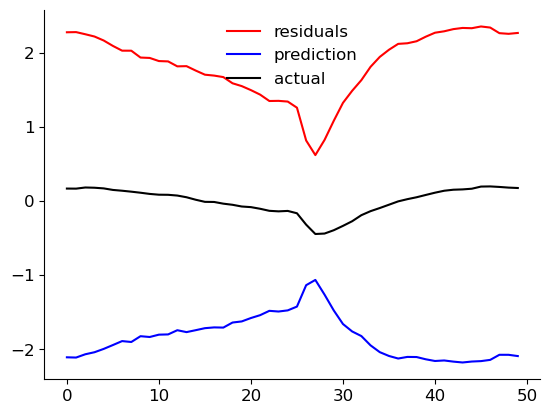

In [127]:
# residuals_list_mean = np.mean(residuals_list, axis=1)
residual_list_mean = []
predicted_list_mean = []
activity_list_mean = []
MSE_kernel_list = []
for i in range(len(residuals_list)):
    residual_list_mean.append(np.mean(residuals_list[i], axis=1))
    predicted_list_mean.append(np.mean(predicted_activity_list[i], axis=1))
    activity_list_mean.append(np.mean(activity_list[i], axis=1))
    residual_MSE = np.mean(np.square(residual))
    MSE_kernel_list.append(residual_MSE)
#     print(f"residual_MSE {residual_MSE}")
    
    
residual_array = np.array(residual_list_mean)
residual_array_mean = np.mean(residual_array, axis=0)

predicted_array = np.array(predicted_list_mean)
predicted_array_mean = np.mean(predicted_array, axis=0)

activity_array = np.array(activity_list_mean)
activity_array_mean = np.mean(activity_array, axis=0)


plt.figure()
plt.plot(residual_array_mean, label="residuals", color='r')
plt.plot(predicted_array_mean, label="prediction", color='b')
plt.plot(activity_array_mean, label="actual", color='k')
plt.legend()
plt.show()

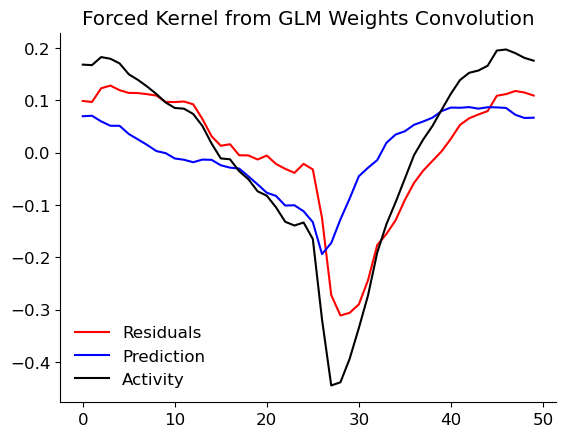

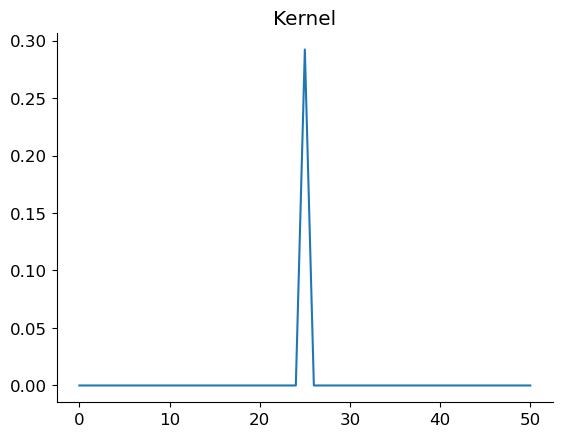

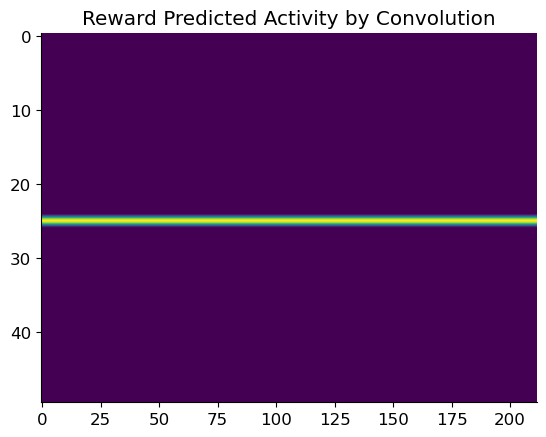

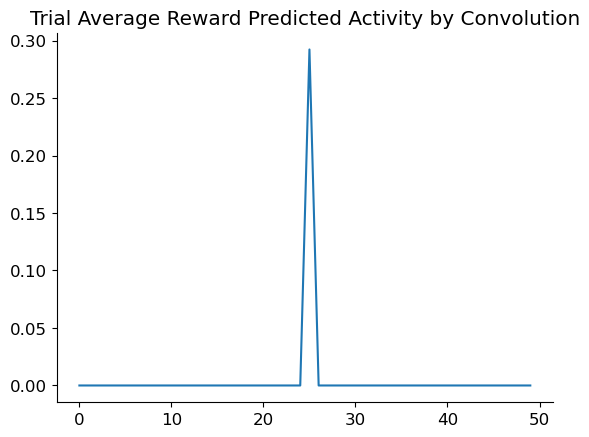

In [188]:
    
def force_kernel_have_GLM_weight_bias(GLM_params_SST, len_kernel=51, kernel_middle=25):
    forced_prediction_real_data = []
    forced_residuals_real_data = []
    activity_list = []
    kernel_every_cell_list_forced = []

    for animal in GLM_params_SST:
        for neuron in GLM_params_SST[animal]:
            weight = GLM_params_SST[animal][neuron]['weights']['Velocity']
            bias = GLM_params_SST[animal][neuron]['intercept']
            forced_kernel = np.zeros(len_kernel)
            forced_kernel[kernel_middle] = weight
            kernel_every_cell_list_forced.append(forced_kernel)
            flat_velocity = factors_dict_SST[animal]['Velocity'].flatten()
            activity = activity_dict_SST[animal][neuron]
            activity_list.append(np.mean(activity, axis=1))
            forced_prediction = np.convolve(flat_velocity, forced_kernel, mode="same") + bias
            prediction = forced_prediction.reshape(activity.shape)
            forced_prediction_real_data.append(np.mean(prediction, axis=1))

            residual = activity - prediction 
            forced_residuals_real_data.append(np.mean(residual, axis=1))
            
    forced_prediction_real_data, forced_residuals_real_data, activity_list, kernel_every_cell_list_forced = force_kernel_have_GLM_weight_bias(GLM_params_SST, len_kernel=51, kernel_middle=25)


residual_array = np.array(forced_residuals_real_data)
residual_array = np.mean(residual_array, axis=0)
prediction_array = np.array(forced_prediction_real_data)
prediction_array = np.mean(prediction_array, axis=0)
activity_array = np.array(activity_list)
activity_array = np.mean(activity_array, axis=0)

plt.figure()
plt.plot(residual_array, label="Residuals", color='r')
plt.plot(prediction_array, label="Prediction", color='b')
plt.plot(activity_array, label="Activity", color='k')
plt.title("Forced Kernel from GLM Weights Convolution")
plt.legend()
plt.show()


def make_reward_locs_arrays(activity_dict_SST):
    
    reward_loc_list = []
    
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            rows = activity_dict_SST[animal][neuron].shape[0]
            columns = activity_dict_SST[animal][neuron].shape[1]
            array_zero = np.zeros((rows, columns))
            array_zero[25,:] = 1
            reward_loc_list.append(array_zero)
            
    return reward_loc_list
         
reward_loc_list = make_reward_locs_arrays(activity_dict_SST)
    

reward_predicted_activity_list = []
reward_predicted_activity_list_trial_av = []

for idx in range(len(reward_loc_list)):
    forced_kernel = kernel_every_cell_list_forced[idx]
    reward_loc = reward_loc_list[idx]
    reward_loc_flat = reward_loc.flatten()
    
    reward_predicted_activity = np.convolve(forced_kernel, reward_loc_flat, mode='same')
    
    reward_predicted_activity = reward_predicted_activity.reshape(reward_loc.shape)
    
    reward_predicted_activity_list_trial_av.append(np.mean(reward_predicted_activity, axis=1))
    
    reward_predicted_activity_list.append(reward_predicted_activity)
    
    
plt.figure()
plt.plot(kernel_every_cell_list_forced[1])
plt.title("Kernel")
plt.show()

plt.figure()
plt.imshow(reward_predicted_activity_list[1], aspect='auto')
plt.title("Reward Predicted Activity by Convolution")
plt.show()

plt.figure()
plt.plot(reward_predicted_activity_list_trial_av[1])
plt.title("Trial Average Reward Predicted Activity by Convolution")
plt.show()


######################### do i have to build a seperate kernel to smooth the reward signal with 

0.04758980196479387

In [ ]:
############################# getting the kernel that convolves velocoity to get activity

In [4]:
per_cell_velocity = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

activity_list = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(activity_dict_SST[animal][neuron])

velocity_flat = per_cell_velocity[0].flatten()
activity_flat = activity_list[0].flatten()

def make_exponential_kernel(length=50, decay_rate=0.1):
    t = np.arange(length)
    kernel = np.exp(-decay_rate * t)
    kernel /= np.sum(kernel)  
    return kernel 

kernel_test = make_exponential_kernel(length=50, decay_rate=0.1)
print(f"AUC Kernel Input: {np.sum(kernel_test)}")

def blind_deconvolve_error(kernel, filtered_signal, orig_signal):    
    guess_filtered_signal = np.convolve(orig_signal, kernel, mode='same')[:len(orig_signal)]
    error = np.sum(np.square(filtered_signal - guess_filtered_signal))
    return error

error = blind_deconvolve_error(kernel_test, activity_flat, velocity_flat)
print(f"error {error}")

AUC Kernel Input: 0.9999999999999999
error 12454.710339580794


optimal_length 50
Optimal Decay Rate: 0.08440726906402644
optimal_shift 10
Optimal Kernel: [0.08215018 0.07550069 0.06938943 0.06377283 0.05861086 0.05386671
 0.04950657 0.04549936 0.0418165  0.03843174 0.03532095 0.03246196
 0.02983439 0.0274195  0.02520008 0.02316031 0.02128564 0.01956272
 0.01797925 0.01652395 0.01518645 0.01395721 0.01282747 0.01178918
 0.01083492 0.00995791 0.00915189 0.0084111  0.00773028 0.00710457
 0.0065295  0.00600099 0.00551525 0.00506883 0.00465854 0.00428146
 0.00393491 0.0036164  0.00332368 0.00305465 0.0028074  0.00258016
 0.00237131 0.00217937 0.00200297 0.00184084 0.00169184 0.00155489
 0.00142904 0.00131337]


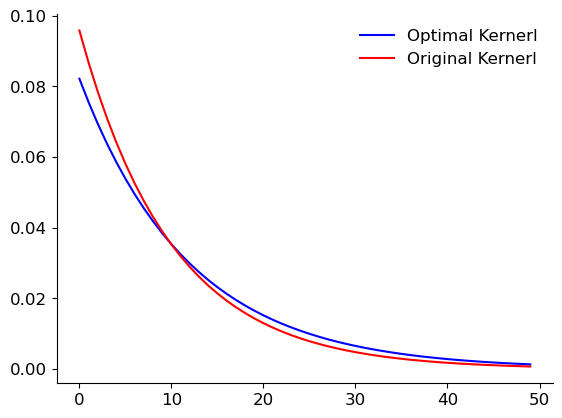

In [10]:
import numpy as np
from scipy.optimize import minimize

def make_exponential_kernel(length=50, decay_rate=0.1, shift=0):
    t = np.arange(length)
    kernel = np.exp(-decay_rate * t)
    kernel /= np.sum(kernel)  # Normalize the kernel
    return kernel 

def blind_deconvolve_error(params, filtered_signal, orig_signal):
    length = int(params[0])
    decay_rate = params[1]
    shift = int(params[2])
    
    kernel = make_exponential_kernel(length=50, decay_rate=decay_rate)
    guess_filtered_signal = np.convolve(orig_signal, kernel, mode='same')[:len(orig_signal)]
    error = np.sum(np.square(filtered_signal - guess_filtered_signal))
    return error

velocity_flat = per_cell_velocity[0].flatten()
activity_flat = activity_list[0].flatten()

def objective(params):
    return blind_deconvolve_error(params, activity_flat, velocity_flat)

initial_guess = [50, 0.1, 10]

bounds = [(10, 100), (0.001, 1.0), (0, 50)]  

result = minimize(objective, initial_guess, bounds=bounds)

optimal_length = int(result.x[0])
optimal_decay_rate = result.x[1]
optimal_shift = int(result.x[2])

print(f"optimal_length {optimal_length}")
print(f"Optimal Decay Rate: {optimal_decay_rate}")
print(f"optimal_shift {optimal_shift}")

optimal_kernel = make_exponential_kernel(length=optimal_length, decay_rate=optimal_decay_rate, shift=optimal_shift)
print(f"Optimal Kernel: {optimal_kernel}")

plt.figure()
plt.plot(optimal_kernel, label="Optimal Kernerl", color='b')
plt.plot(kernel_test, label="Original Kernerl", color='r')
plt.legend()
plt.show()


Optimal Length: 50
Optimal Decay Rate: 0.08193167380907047
Optimal Shift: 10
Optimal Kernel: [0.04497925 0.04497925 0.04497925 0.04497925 0.04497925 0.04497925
 0.04497925 0.04497925 0.04497925 0.04497925 0.04497925 0.04144095
 0.038181   0.03517748 0.03241024 0.02986069 0.02751169 0.02534748
 0.02335352 0.02151642 0.01982382 0.01826438 0.01682761 0.01550387
 0.01428425 0.01316058 0.0121253  0.01117147 0.01029266 0.00948299
 0.00873701 0.00804971 0.00741648 0.00683306 0.00629554 0.0058003
 0.00534402 0.00492363 0.00453631 0.00417946 0.00385068 0.00354777
 0.00326868 0.00301155 0.00277465 0.00255638 0.00235528 0.00217
 0.0019993  0.00184203]


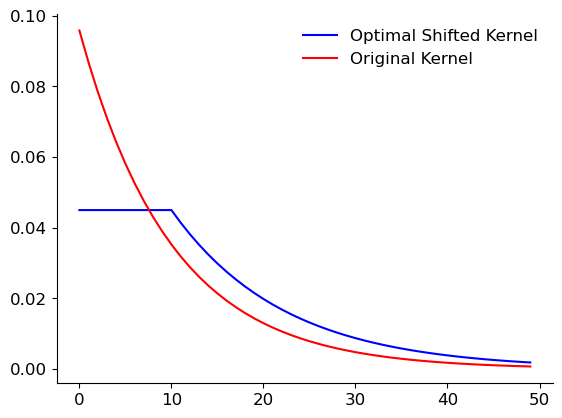

In [12]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def make_shifted_exponential_kernel(length=50, decay_rate=0.1, shift=0):
    t = np.arange(length) - shift
    t[t < 0] = 0  
    kernel = np.exp(-decay_rate * t)
    kernel /= np.sum(kernel)  
    return kernel 

def blind_deconvolve_error(params, filtered_signal, orig_signal):
    length = int(params[0])        
    decay_rate = params[1]         
    shift = int(params[2])         
    
    kernel = make_shifted_exponential_kernel(length=length, decay_rate=decay_rate, shift=shift)
    guess_filtered_signal = np.convolve(orig_signal, kernel, mode='same')[:len(orig_signal)]
    error = np.sum(np.square(filtered_signal - guess_filtered_signal))
    return error

velocity_flat = per_cell_velocity[0].flatten()
activity_flat = activity_list[0].flatten()

def objective(params):
    return blind_deconvolve_error(params, activity_flat, velocity_flat)

initial_guess = [50, 0.1, 10]

bounds = [(10, 100), (0.001, 1.0), (0, 50)]

result = minimize(objective, initial_guess, bounds=bounds)

optimal_length = int(result.x[0])
optimal_decay_rate = result.x[1]
optimal_shift = int(result.x[2])

print(f"Optimal Length: {optimal_length}")
print(f"Optimal Decay Rate: {optimal_decay_rate}")
print(f"Optimal Shift: {optimal_shift}")

optimal_kernel = make_shifted_exponential_kernel(length=optimal_length, decay_rate=optimal_decay_rate, shift=optimal_shift)
print(f"Optimal Kernel: {optimal_kernel}")

plt.figure()
plt.plot(optimal_kernel, label="Optimal Shifted Kernel", color='b')
plt.plot(kernel_test, label="Original Kernel", color='r')
plt.legend()
plt.show()








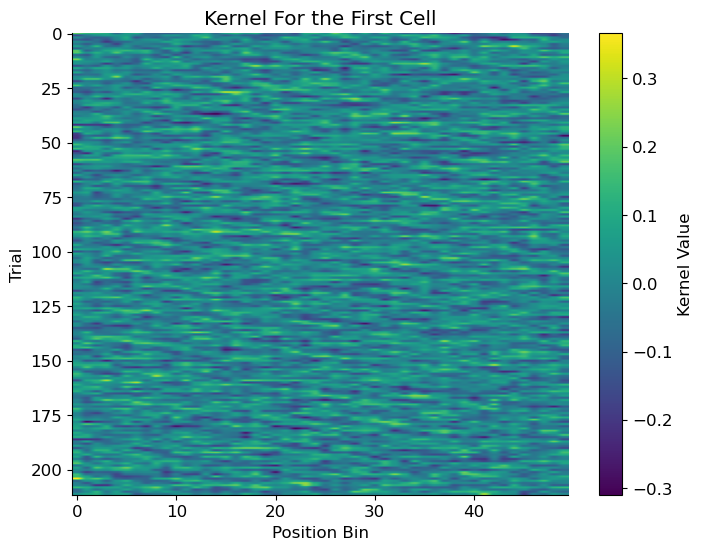

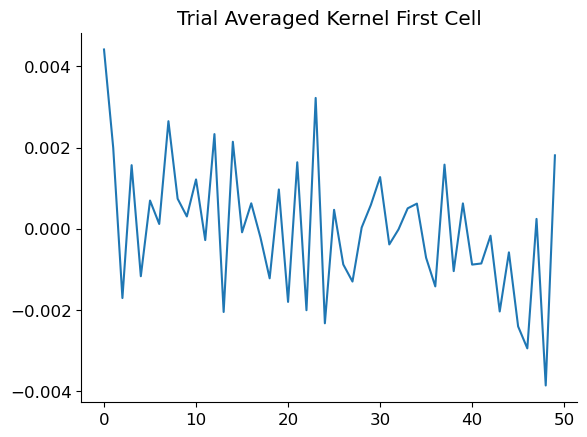

(75, 50)


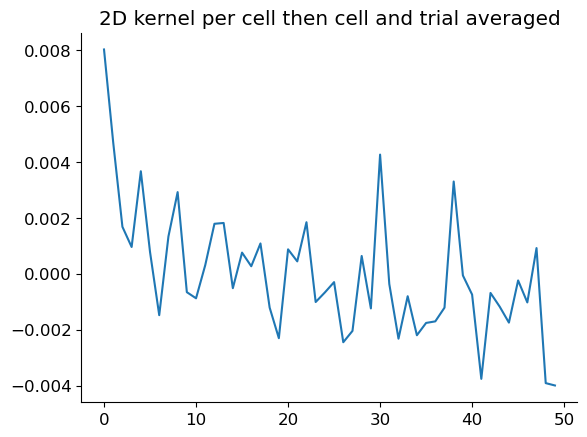

In [68]:

def deconvolve_kernel(neural_activity, velocity, reg_factor=1e-6):

    SF = np.fft.fft2(neural_activity)
    FF = np.fft.fft2(velocity)
    
    GF = SF / (FF + reg_factor)

    kernel = np.fft.ifft2(GF).real  
    
    return kernel




plt.figure(figsize=(8, 6))
plt.imshow(kernel.T, aspect="auto", cmap="viridis")
plt.colorbar(label="Kernel Value")
plt.xlabel("Position Bin")
plt.ylabel("Trial")
plt.title("Kernel For the First Cell")
plt.show()

plt.figure()
plt.plot(np.mean(kernel, axis=1))
plt.title("Trial Averaged Kernel First Cell")
plt.xlabel("Position Bin")
plt.show()

############### getting a kernel for each cell and then taking the average of that 

kernel_list = []

for i in range(len(activity_list)):
    neural_activity = activity_list[i]
    velocity = per_cell_velocity[i]
    kernel = deconvolve_kernel(neural_activity, velocity, reg_factor=1e-6)
    kernel_list.append(np.mean(kernel, axis=1))
    
kernel_array = np.array(kernel_list)
print(kernel_array.shape)
cell_average_kernel = np.mean(kernel_array, axis=0)

plt.figure()
plt.plot(cell_average_kernel)
plt.title("2D kernel per cell then cell and trial averaged")
plt.xlabel("Position Bin")
plt.show()

    

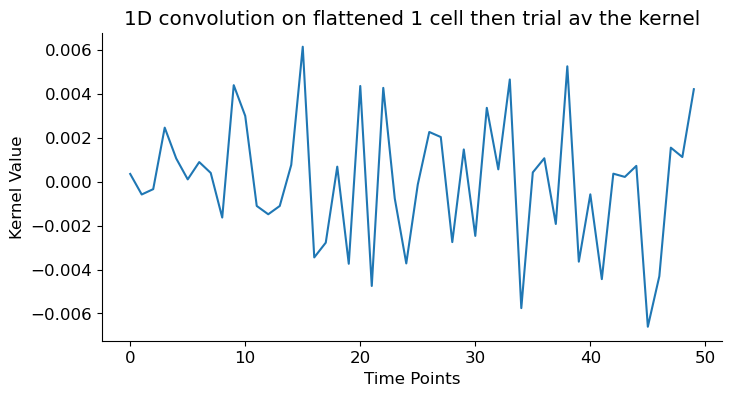

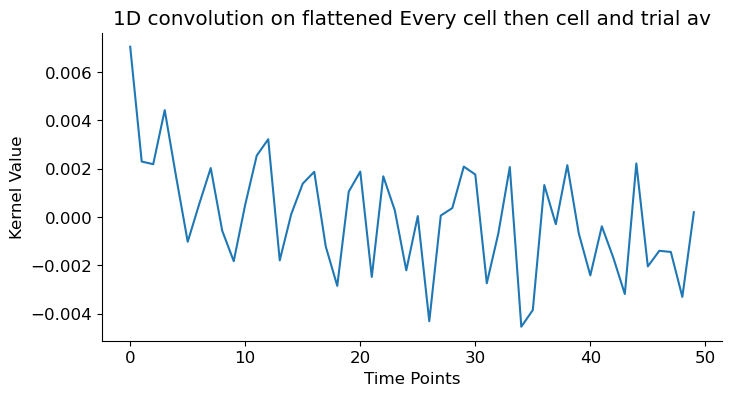

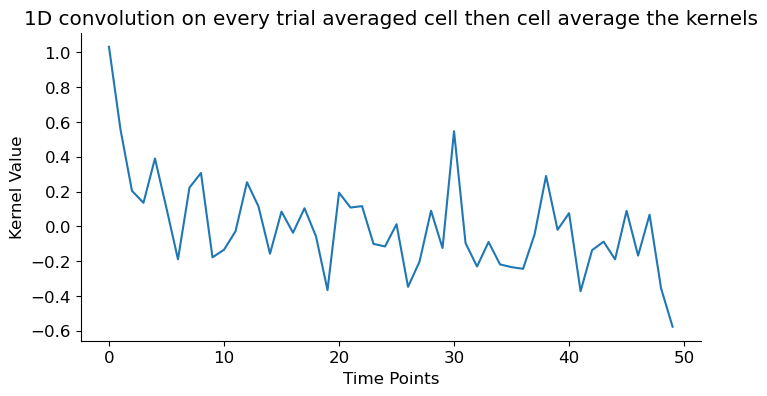

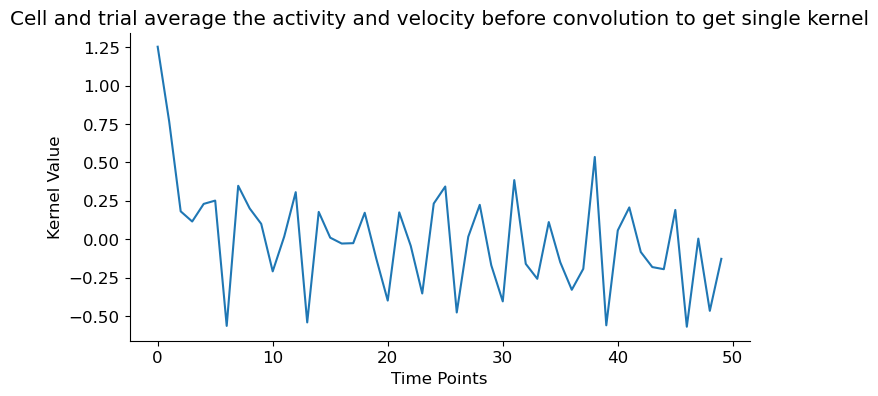

In [85]:

def deconvolve_kernel_1d(neural_activity, velocity, reg_factor=1e-6):
    
    neural_activity = neural_activity.flatten()
    velocity = velocity.flatten()
    
    
    SF = np.fft.fft(neural_activity)
    FF = np.fft.fft(velocity)
    
    GF = SF / (FF + reg_factor)
    
    kernel = np.fft.ifft(GF).real  # Take real part

    return kernel


neural_activity_1d = activity_list[0].flatten()
velocity_1d = per_cell_velocity[0].flatten()

kernel_1d = deconvolve_kernel_1d(neural_activity_1d, velocity_1d)
kernel_1d = kernel_1d.reshape(activity_list[0].shape)
trial_av_kernel = np.mean(kernel_1d, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(trial_av_kernel)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("1D convolution on flattened 1 cell then trial av the kernel")
plt.show()

#### average of all the kernels== kernels see all the data  

kernel_list = []

for i in range(len(activity_list)):
    neural_activity_1d = activity_list[i].flatten()
    velocity_1d = per_cell_velocity[i].flatten()

    kernel_1d = deconvolve_kernel_1d(neural_activity_1d, velocity_1d)
    kernel_1d = kernel_1d.reshape(activity_list[i].shape)
    kernel_list.append(np.mean(kernel_1d, axis=1))

kernel_array = np.array(kernel_list)
kernel = np.mean(kernel_array, axis=0)
    
plt.figure(figsize=(8, 4))
plt.plot(kernel)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("1D convolution on flattened Every cell then cell and trial av")
plt.show()


kernel_list = []

for i in range(len(activity_list)):
    neural_activity_1d = np.mean(activity_list[i], axis=1)
    velocity_1d = np.mean(per_cell_velocity[i], axis=1)

    kernel_1d = deconvolve_kernel_1d(neural_activity_1d, velocity_1d)
    kernel_list.append(kernel_1d)
    
kernel_array = np.array(kernel_list)
kernel = np.mean(kernel_array, axis=0)
    
plt.figure(figsize=(8, 4))
plt.plot(kernel)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("1D convolution on every trial averaged cell then cell average the kernels")
plt.show()



cell_and_trial_averaged_activity = []
cell_and_trial_averaged_velocity = []

for i in range(len(activity_list)):
    neural_activity_1d = np.mean(activity_list[i], axis=1)
    cell_and_trial_averaged_activity.append(neural_activity_1d)
    velocity_1d = np.mean(per_cell_velocity[i], axis=1)
    cell_and_trial_averaged_velocity.append(velocity_1d)
    
cell_and_trial_averaged_activity_array = np.stack(cell_and_trial_averaged_activity)
cell_and_trial_averaged_velocity_array = np.stack(cell_and_trial_averaged_velocity)

activity = np.mean(cell_and_trial_averaged_activity_array, axis=0)
velocity = np.mean(cell_and_trial_averaged_velocity_array, axis=0)

kernel_average = deconvolve_kernel_1d(activity, velocity)

plt.figure(figsize=(8, 4))
plt.plot(kernel_average)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("Cell and trial average the activity and velocity before convolution to get single kernel")
plt.show()

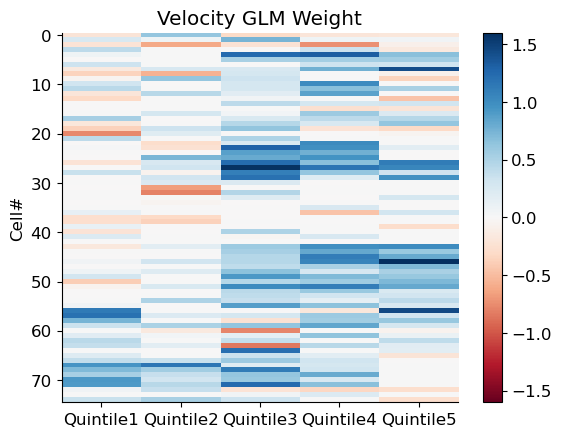

In [353]:


def get_weights_per_quintile(activity_dict_SST, use_GAM=False):
    per_cell_velocity = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])
            
    

    activity_list = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            activity_list.append(activity_dict_SST[animal][neuron])  

    each_cell_weights_list = []

    for idx, cell in enumerate(activity_list):
        num_trials = cell.shape[1]  
        quintile_size = num_trials // 5  

        gaussian_quintiles = [] 
        velocity_quintiles = []
        ground_truth_quintiles_list = []

        for i in range(5):  
            start_idx = i * quintile_size 
            end_idx = num_trials if i == 4 else (i + 1) * quintile_size  

            gaussian_quintile = cell[:, start_idx:end_idx] 
            gaussian_quintiles.append(gaussian_quintile) 

            velocity_quintile = per_cell_velocity[i][:, start_idx:end_idx] 
            velocity_quintiles.append(velocity_quintile)

            ground_truth_quintile = a[:, start_idx:end_idx]
            ground_truth_quintiles_list.append(ground_truth_quintile)

        weight_per_quintile_list = []

        for i in range(5):
            gaussian_quintile  = gaussian_quintiles[i]
            velocity_quintile = velocity_quintiles[i]

            neuron_activity_flat = gaussian_quintile.flatten()
            flattened_velocity = velocity_quintile.flatten().reshape(-1, 1)  

            if use_GAM:
                model = LinearGAM().fit(flattened_velocity, neuron_activity_flat)
                weight = model.coef_  
            else:
                alphas = [0.1, 1, 10, 100, 1000, 5000]
                model = RidgeCV(alphas=alphas, cv=None)
                model.fit(flattened_velocity, neuron_activity_flat)
                weight = model.coef_[0]

            weight_per_quintile_list.append(weight) 

        each_cell_weights_list.append(weight_per_quintile_list)
        
    return each_cell_weights_list

each_cell_weights_list = get_weights_per_quintile(activity_dict_SST, use_GAM=False)


def plot_weights_per_quintile(each_cell_weights_list):

    each_cell_weights_list_array = np.array(each_cell_weights_list)
    
    plt.imshow(each_cell_weights_list_array, aspect="auto", cmap='RdBu', vmin=-1.6, vmax=1.6)
    plt.xticks(ticks=np.arange(5), labels=[f"Quintile{i+1}" for i in range(5)])
    plt.ylabel("Cell#")
    plt.title("Velocity GLM Weight")
    plt.colorbar()
    plt.plot()

plot_weights_per_quintile(each_cell_weights_list)



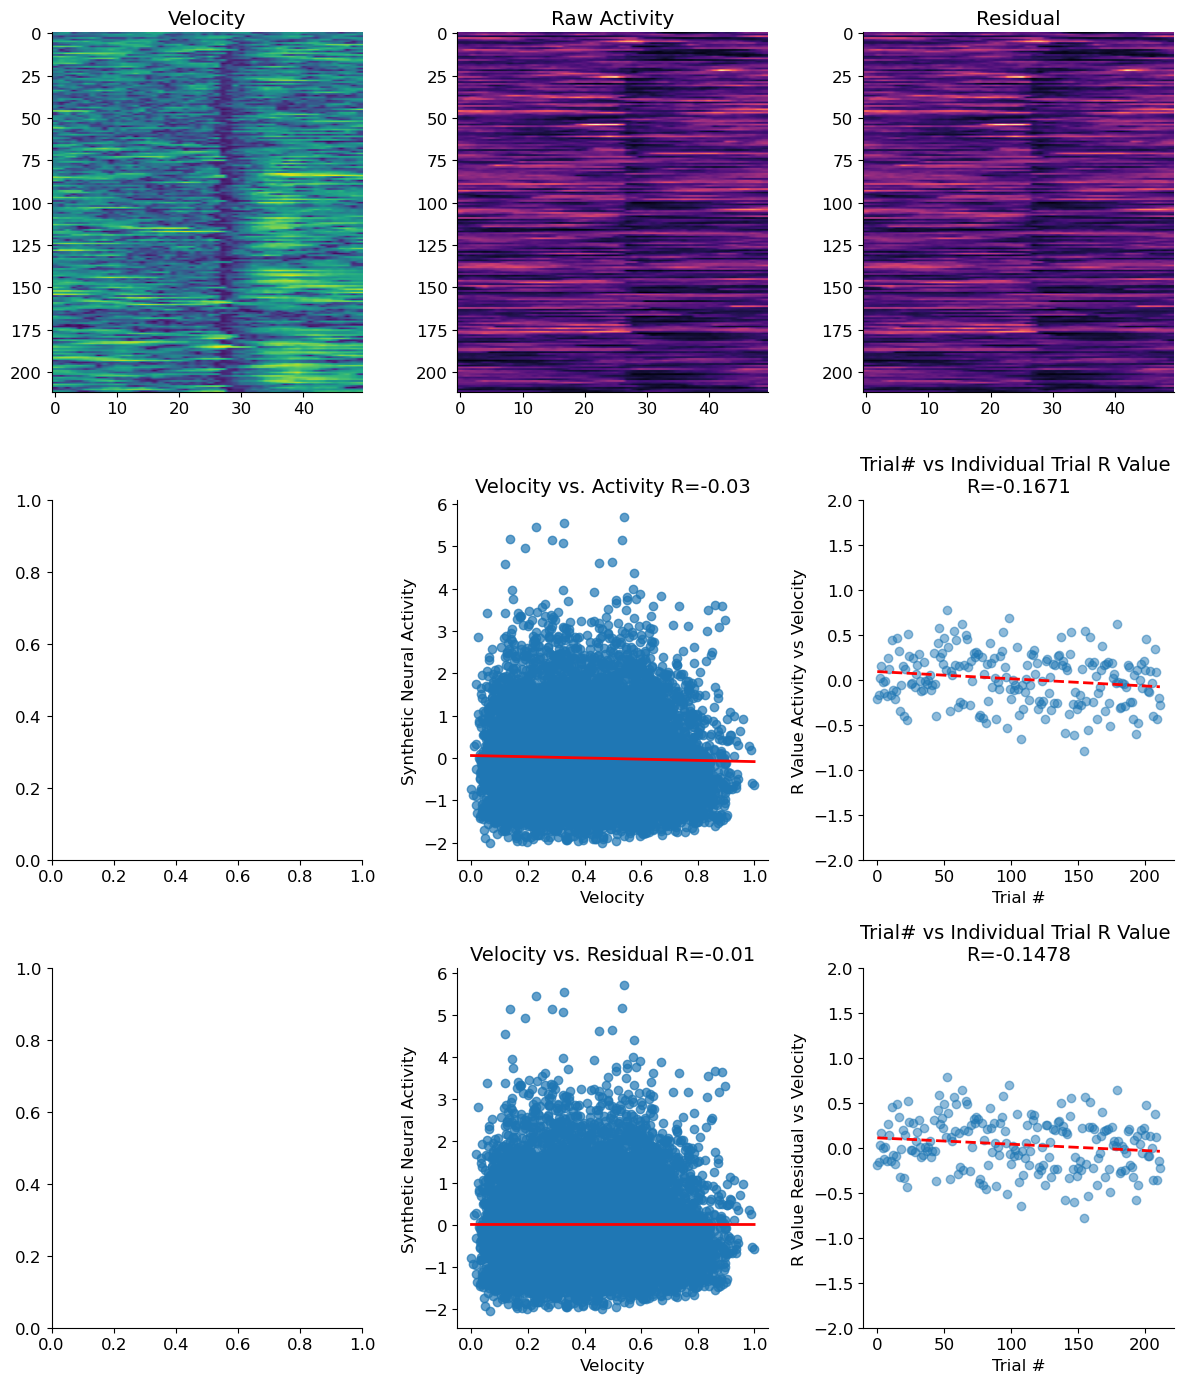

In [149]:

neuron_activity_list, predictions_list, cell_residual_list = get_neuron_activity_prediction_residual(activity_dict_SST, predicted_activity_dict_SST)
velocity = per_cell_velocity[0]
activity = neuron_activity_list[0]
residual = cell_residual_list[0]
prediction = predictions_list[0]

fig, axs = plt.subplots(3,3,  figsize=(12, 14))

axs[0, 0].imshow(velocity.T, aspect="auto")
axs[0, 0].set_title("Velocity")

axs[0, 1].imshow(activity.T, aspect="auto", cmap='magma')
axs[0, 1].set_title("Raw Activity")

axs[0, 2].imshow(residual.T, aspect="auto", cmap='magma')
axs[0, 2].set_title("Residual")

prediction_velocity_correlation_list = []
activity_velocity_correlation_list = []
residual_velocity_correlation_list = []

for i in range(activity.shape[1]):
    trial_predicted_activity = prediction[:, i]
    trial_velocity = velocity[:, i]
    trial_activity = activity[:, i]
    trial_residual = residual[:, i]

    prediction_velocity_correlation, _ = pearsonr(trial_predicted_activity, trial_velocity)
    prediction_velocity_correlation_list.append(prediction_velocity_correlation)

    activity_velocity_correlation, _ = pearsonr(trial_activity, trial_velocity)
    activity_velocity_correlation_list.append(activity_velocity_correlation)

    residual_velocity_correlation, _ = pearsonr(trial_residual, trial_velocity)
    residual_velocity_correlation_list.append(residual_velocity_correlation)
    
    
    
    
    
num_trials = residual.shape[1] 
quintile_size = num_trials // 5

divide_data_by_velocity = np.where(velocity != 0, combined_gaussian_with_velocity / velocity, 0)

residual_q1 = residual[:, :quintile_size]  
residual_q5 = residual[:, -quintile_size:] 

activity_q1 = activity[:, :quintile_size]
activity_q5 = activity[:, -quintile_size:]

divided_q1 = divide_data_by_velocity[:, :quintile_size]
divided_q5 = divide_data_by_velocity[:, -quintile_size:]

mean_residual_q1 = np.mean(residual_q1, axis=1)
mean_residual_q5 = np.mean(residual_q5, axis=1)

mean_activity_q1 = np.mean(activity_q1, axis=1)
mean_activity_q5 = np.mean(activity_q5, axis=1)

mean_divided_q1 = np.mean(divided_q1, axis=1)
mean_divided_q5 = np.mean(divided_q5, axis=1)



axs[1, 0].plot(mean_activity_q1, color='r', label="Q1 Activity", marker='o', markersize=3, alpha=0.8)
axs[1, 0].plot(mean_activity_q5, color='b', label="Q5 Activity", marker='x', markersize=3, alpha=0.8)
axs[1, 0].set_xlabel("Position Bin", fontsize=12)
axs[1, 0].set_ylabel("Mean Activity", fontsize=12)
axs[1, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
axs[1, 0].set_ylim(min_data1-0.2, max_data1+0.2)
axs[1, 0].legend(fontsize=10)
    
flat_velocity = velocity.flatten()
flat_activity = activity.flatten()

slope, intercept, r_value, p_value, std_err = linregress(flat_velocity, flat_activity)
x_vals = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
y_vals = slope * x_vals + intercept

velocity_activity_corr, _ = pearsonr(flat_velocity, flat_activity)
axs[1, 1].scatter(flat_velocity, flat_activity, alpha=0.7)
axs[1, 1].plot(x_vals, y_vals, color='red', linewidth=2, label="Best Fit Line")
axs[1, 1].set_xlabel("Velocity", fontsize=12)
axs[1, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
axs[1, 1].set_title(f"Velocity vs. Activity R={velocity_activity_corr:.2f}", fontsize=14)
    
    
    
trial_numbers=np.arange(len(activity_velocity_correlation_list))
slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, activity_velocity_correlation_list)
trend_line = intercept + slope*trial_numbers

activity_corr_array = np.array(activity_velocity_correlation_list)
r_value_over_trials, _ = pearsonr(trial_numbers, activity_corr_array)

axs[1, 2].scatter(trial_numbers, activity_velocity_correlation_list, alpha=0.5, label="Data")
axs[1, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
axs[1, 2].set_xlabel("Trial #", fontsize=12)
axs[1, 2].set_ylabel("R Value Activity vs Velocity", fontsize=12)
axs[1, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
axs[1, 2].set_ylim(-2, 2)





    
flat_velocity = velocity.flatten()
flat_residual = residual.flatten()

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(flat_velocity, flat_residual)
x_vals2 = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
y_vals2 = slope * x_vals + intercept2

velocity_residual_corr, _ = pearsonr(flat_velocity, flat_residual)
axs[2, 1].scatter(flat_velocity, flat_residual, alpha=0.7)
axs[2, 1].plot(x_vals2, y_vals2, color='red', linewidth=2, label="Best Fit Line")
axs[2, 1].set_xlabel("Velocity", fontsize=12)
axs[2, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
axs[2, 1].set_title(f"Velocity vs. Residual R={velocity_residual_corr:.2f}", fontsize=14)


    
    
trial_numbers=np.arange(len(residual_velocity_correlation_list))
slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, residual_velocity_correlation_list)
trend_line = intercept + slope*trial_numbers

residual_corr_array = np.array(residual_velocity_correlation_list)
r_value_over_trials, _ = pearsonr(trial_numbers, residual_corr_array)

axs[2, 2].scatter(trial_numbers, residual_velocity_correlation_list, alpha=0.5, label="Data")
axs[2, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
axs[2, 2].set_xlabel("Trial #", fontsize=12)
axs[2, 2].set_ylabel("R Value Residual vs Velocity", fontsize=12)
axs[2, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
axs[2, 2].set_ylim(-2, 2)












plt.tight_layout()
plt.show()




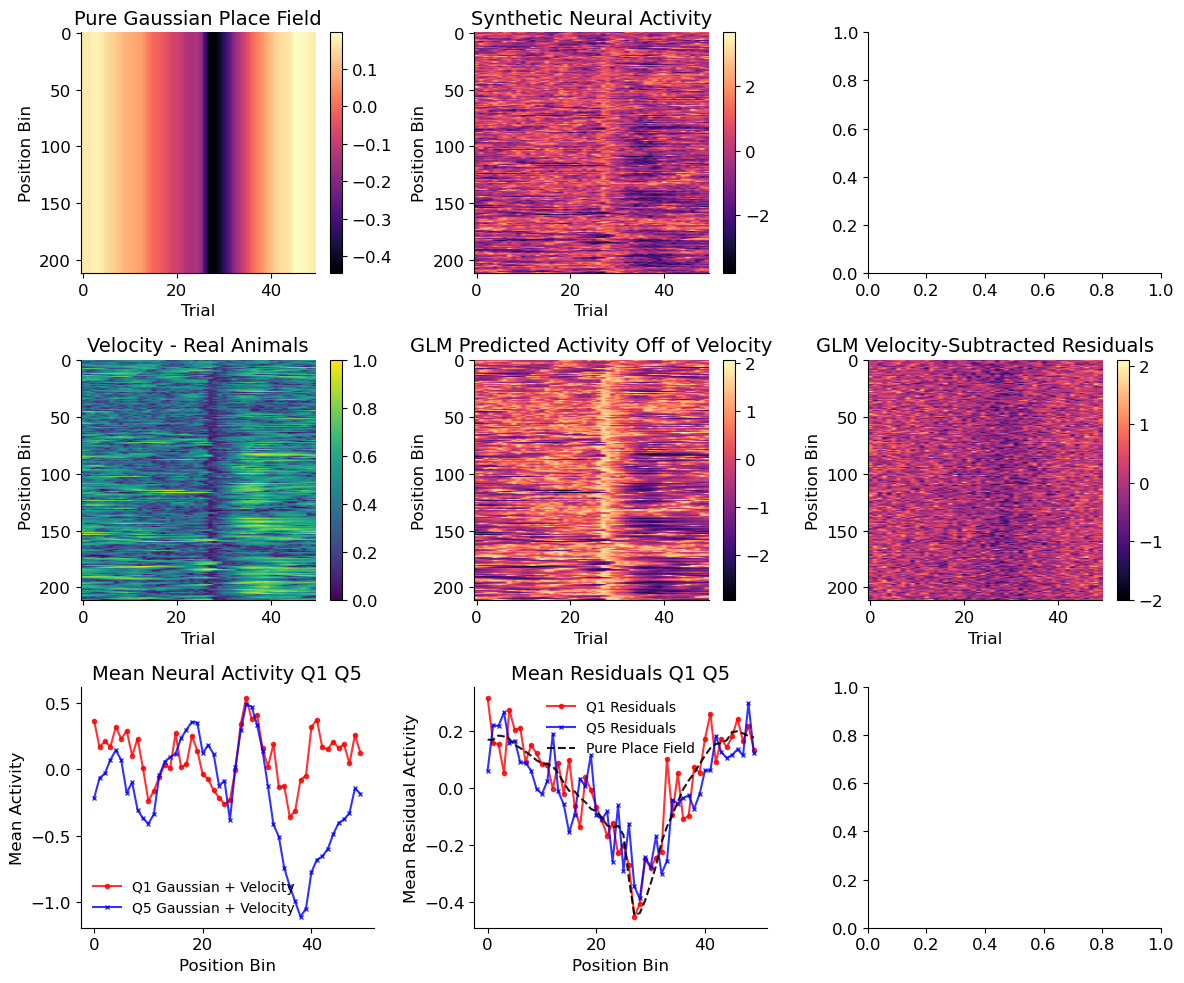

In [5]:
##### velocity plotted over cell trace

weight = -5
noise_sf = 0.5
pf_scale = np.linspace(0, 1, 212)
# pf_position = 


per_cell_velocity = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

        
x = np.arange(50)

activity_list = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

neurons_array = np.stack(activity_list) 
combined_gaussian = np.mean(neurons_array, axis=0)

num_trials = per_cell_velocity[0].shape[1]


################# plotting pure gaussian place fields

a = np.tile(combined_gaussian, (num_trials, 1)).T

################# pure velocity data

velocity = per_cell_velocity[0]

################# plotting velocity-correlated activity


velocity_correlation = weight*velocity

combined_gaussian_with_velocity = a + velocity_correlation

combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

noise = noise_sf * np.random.normal(0, 1, a.shape)
combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise


################# fitting a GLM and getting velocity prediction 

neuron_activity_flat = combined_gaussian_with_velocity.flatten()
flattened_data = velocity.flatten()

alphas=None

model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)


################## plotting the residuals 

residual = combined_gaussian_with_velocity - neuron_predicted_activity


################## plotting quintiles 


num_trials = residual.shape[1] 
quintile_size = num_trials // 5

residual_q1 = residual[:, :quintile_size]  # First 1/5th
residual_q5 = residual[:, -quintile_size:]  # Last 1/5th

gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]


mean_residual_q1 = np.mean(residual_q1, axis=1)
mean_residual_q5 = np.mean(residual_q5, axis=1)

mean_gaussian_q1 = np.mean(gaussian_q1, axis=1)
mean_gaussian_q5 = np.mean(gaussian_q5, axis=1)


#############################

fig, axs = plt.subplots(3, 3, figsize=(12, 10))  # Increase figure size

im1 = axs[0, 0].imshow(a.T, cmap='magma', aspect='auto')
axs[0, 0].set_xlabel("Trial", fontsize=12)
axs[0, 0].set_ylabel("Position Bin", fontsize=12)
axs[0, 0].set_title("Pure Gaussian Place Field", fontsize=14)
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(combined_gaussian_with_velocity.T, cmap='magma', aspect='auto')
axs[0, 1].set_xlabel("Trial", fontsize=12)
axs[0, 1].set_ylabel("Position Bin", fontsize=12)
axs[0, 1].set_title("Synthetic Neural Activity", fontsize=14)
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(velocity.T, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Velocity - Real Animals", fontsize=14)
axs[1, 0].set_xlabel("Trial", fontsize=12)
axs[1, 0].set_ylabel("Position Bin", fontsize=12)
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(neuron_predicted_activity.T, cmap='magma', aspect='auto')
axs[1, 1].set_xlabel("Trial", fontsize=12)
axs[1, 1].set_ylabel("Position Bin", fontsize=12)
axs[1, 1].set_title("GLM Predicted Activity Off of Velocity", fontsize=14)
fig.colorbar(im4, ax=axs[1, 1])

im5 = axs[1, 2].imshow(residual.T, cmap='magma', aspect='auto')
axs[1, 2].set_xlabel("Trial", fontsize=12)
axs[1, 2].set_ylabel("Position Bin", fontsize=12)
axs[1, 2].set_title("GLM Velocity-Subtracted Residuals", fontsize=14)
fig.colorbar(im5, ax=axs[1, 2])

axs[2, 0].plot(mean_gaussian_q1, color='r', label="Q1 Gaussian + Velocity", marker='o', markersize=3, alpha=0.8)
axs[2, 0].plot(mean_gaussian_q5, color='b', label="Q5 Gaussian + Velocity", marker='x', markersize=3, alpha=0.8)
axs[2, 0].set_xlabel("Position Bin", fontsize=12)
axs[2, 0].set_ylabel("Mean Activity", fontsize=12)
axs[2, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
axs[2, 0].legend(fontsize=10)

axs[2, 1].plot(mean_residual_q1, color='r', label="Q1 Residuals", marker='o', markersize=3, alpha=0.8)
axs[2, 1].plot(mean_residual_q5, color='b', label="Q5 Residuals", marker='x', markersize=3, alpha=0.8)
axs[2, 1].plot(combined_gaussian, color="k", label="Pure Place Field", linestyle="--", alpha=0.9)
axs[2, 1].set_xlabel("Position Bin", fontsize=12)
axs[2, 1].set_ylabel("Mean Residual Activity", fontsize=12)
axs[2, 1].set_title("Mean Residuals Q1 Q5", fontsize=14)
axs[2, 1].legend(fontsize=10)

plt.tight_layout() 
plt.show()



residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_vel_corr_pos_q1 [-0.0076497057076108455, -0.012036099640309756, 0.02450870221599025]
residual_vel_corr_pos_q5 [-0.03662737347023687, -0.020470508843963727, -0.021610943728932873]
residual_vel_corr_neg_q1 []
residual_vel_corr_neg_q5 []


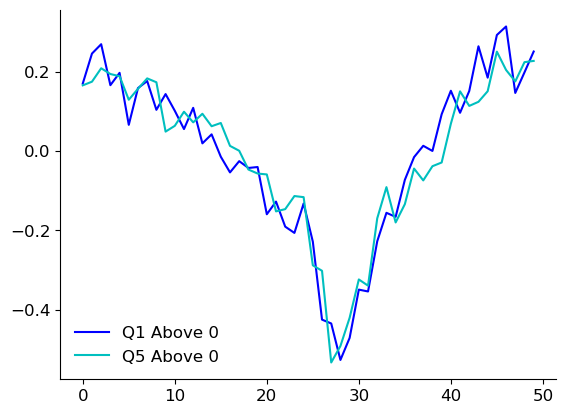

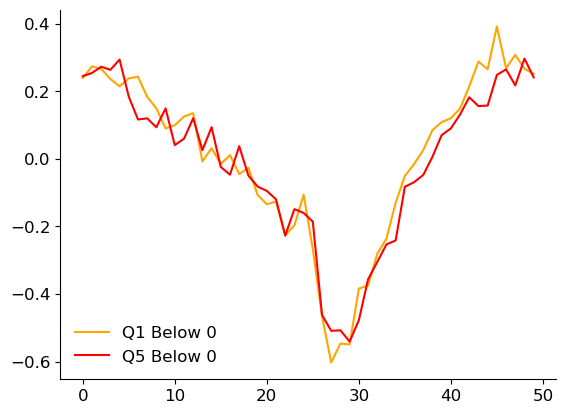

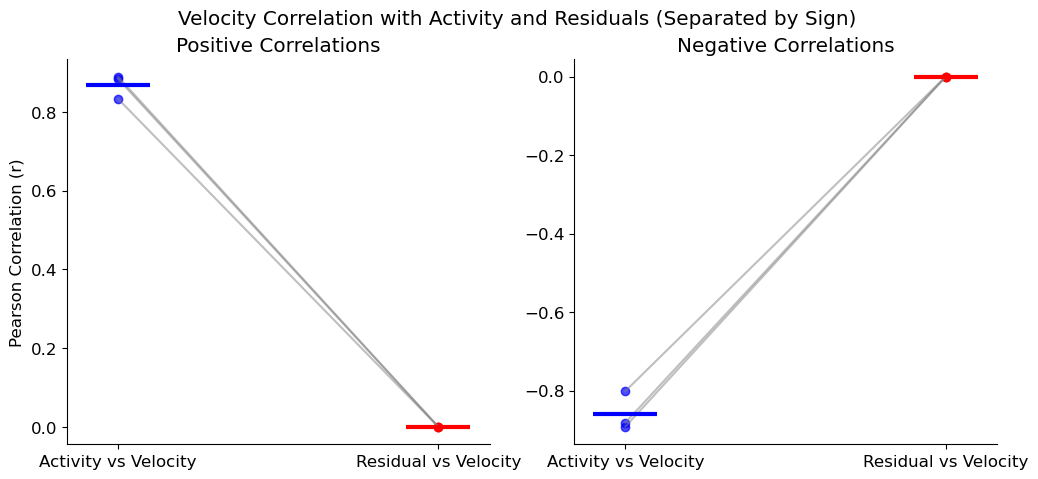

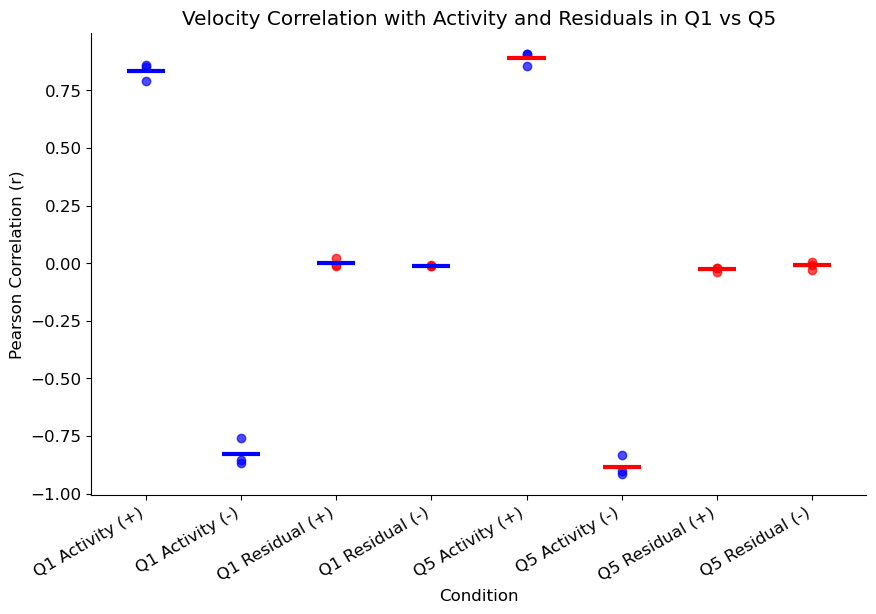

In [103]:
noise_sf=0.5

per_cell_velocity = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

        
x = np.arange(50)

activity_list = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

neurons_array = np.stack(activity_list) 
combined_gaussian = np.mean(neurons_array, axis=0)
combined_gaussian = np.tile(combined_gaussian, (num_trials, 1)).T


weights_list_positive = [2, 5, 10]
weights_list_negative = [-2, -5, -10]

gaussian_positive = []
gaussian_negative = []

for weight in weights_list_positive:
    velocity_correlation = weight*velocity

    combined_gaussian_with_velocity = combined_gaussian + velocity_correlation.T

    combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

    noise = noise_sf * np.random.normal(0, 1, a.shape).T
    
    combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise
    gaussian_positive.append(combined_gaussian_with_velocity.T)
    
for weight in weights_list_negative:
    velocity_correlation = weight*velocity

    combined_gaussian_with_velocity = combined_gaussian + velocity_correlation.T

    combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

    noise = noise_sf * np.random.normal(0, 1, a.shape).T
    combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise
    gaussian_negative.append(combined_gaussian_with_velocity.T)
    

    
velocity = per_cell_velocity[0].T

positive_prediction_list = []
negative_prediction_list = []

for i in gaussian_positive:
    neuron_activity_flat = i.flatten()
    flattened_data = velocity.flatten()

    alphas=None

    model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

    model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

    neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)
    positive_prediction_list.append(neuron_predicted_activity)
    
for i in gaussian_negative:
    neuron_activity_flat = i.flatten()
    flattened_data = velocity.flatten()

    alphas=None

    model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

    model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

    neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)
    negative_prediction_list.append(neuron_predicted_activity)
    
residuals_list_positive = np.subtract(gaussian_positive, positive_prediction_list)
residuals_list_negative = np.subtract(gaussian_negative, negative_prediction_list)


num_trials = residual.shape[1] 
quintile_size = num_trials // 5

residual_q1 = residual[:, :quintile_size]  
residual_q5 = residual[:, -quintile_size:] 

gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]


residual_list_pos_q1 = []
residual_list_pos_q5 = []
mean_residual_list_pos_q1 = []
mean_residual_list_pos_q5 = []

residual_vel_corr_pos_q1 = []
residual_vel_corr_pos_q5 = []
activity_vel_corr_pos_q1 = []
activity_vel_corr_pos_q5 = []

for idx, i in enumerate(residuals_list_positive):
    residual_q1 = i.T[:, :quintile_size]  
    residual_q5 = i.T[:, -quintile_size:]
    velocity_q1 = velocity.T[:, :quintile_size]  
    velocity_q5 = velocity.T[:, -quintile_size:]
    print(f"residual_q1.shape {residual_q1.shape}")
    print(f"velocity_q1.shape {velocity_q1.shape}")
    residual_list_pos_q1.append(residual_q1)
    residual_list_pos_q5.append(residual_q5)
    mean_residual_list_pos_q1.append(np.mean(residual_q1, axis=1))
    mean_residual_list_pos_q5.append(np.mean(residual_q5, axis=1))
    q1_corr, _ = pearsonr(residual_q1.flatten(), velocity_q1.flatten())
    q5_corr, _ = pearsonr(residual_q5.flatten(), velocity_q5.flatten())
    
    residual_vel_corr_pos_q1.append(q1_corr)
    residual_vel_corr_pos_q5.append(q5_corr)
    
    gaussian_q1 = gaussian_positive[idx].T[:, :quintile_size]  
    gaussian_q5 = gaussian_positive[idx].T[:, -quintile_size:] 
    
    print(f"gaussian_q1.shape {gaussian_q1.shape}")
    print(f"velocity_q1.shape {velocity_q1.shape}")
    
    q1_corr_activity, _ = pearsonr(gaussian_q1.flatten(), velocity_q1.flatten())
    q5_corr_activity, _ = pearsonr(gaussian_q5.flatten(), velocity_q5.flatten())
    activity_vel_corr_pos_q1.append(q1_corr_activity)
    activity_vel_corr_pos_q5.append(q5_corr_activity)
    
print(f"residual_vel_corr_pos_q1 {residual_vel_corr_pos_q1}")
print(f"residual_vel_corr_pos_q5 {residual_vel_corr_pos_q5}")
    
    
residual_list_neg_q1 = []
residual_list_neg_q5 = []
mean_residual_list_neg_q1 = []
mean_residual_list_neg_q5 = []

residual_vel_corr_neg_q1 = []
residual_vel_corr_neg_q5 = []
activity_vel_corr_neg_q1 = []
activity_vel_corr_neg_q5 = []

print(f"residual_vel_corr_neg_q1 {residual_vel_corr_neg_q1}")
print(f"residual_vel_corr_neg_q5 {residual_vel_corr_neg_q5}")

for idx, i in enumerate(residuals_list_negative):
    residual_q1 = i.T[:, :quintile_size]  
    residual_q5 = i.T[:, -quintile_size:]
    velocity_q1 = velocity.T[:, :quintile_size]  
    velocity_q5 = velocity.T[:, -quintile_size:]
    residual_list_neg_q1.append(residual_q1)
    residual_list_neg_q5.append(residual_q5)
    mean_residual_list_neg_q1.append(np.mean(residual_q1, axis=1))
    mean_residual_list_neg_q5.append(np.mean(residual_q5, axis=1))
    q1_corr, _ = pearsonr(residual_q1.flatten(), velocity_q1.flatten())
    q5_corr, _ = pearsonr(residual_q5.flatten(), velocity_q5.flatten())
    residual_vel_corr_neg_q1.append(q1_corr)
    residual_vel_corr_neg_q5.append(q5_corr)
    
    gaussian_q1 = gaussian_negative[idx].T[:, :quintile_size]  
    gaussian_q5 = gaussian_negative[idx].T[:, -quintile_size:]
    
    q1_corr_activity, _ = pearsonr(gaussian_q1.flatten(), velocity_q1.flatten())
    q5_corr_activity, _ = pearsonr(gaussian_q5.flatten(), velocity_q5.flatten())
    activity_vel_corr_neg_q1.append(q1_corr_activity)
    activity_vel_corr_neg_q5.append(q5_corr_activity)
    
        
        
activity_velocity_positive = []
activity_velocity_negative = []

residual_velocity_positive = []
residual_velocity_negative = []


for i in range(len(residual_list_pos_q1)):
    raw_positive = gaussian_positive[i].flatten()
    raw_negative = gaussian_negative[i].flatten()
    res_pos = residuals_list_positive[i].flatten()
    res_neg = residuals_list_negative[i].flatten()
    flat_velocity = velocity.flatten()
    positive_correlation, _ = pearsonr(raw_positive, flat_velocity)
    negative_correlation, _ = pearsonr(raw_negative, flat_velocity)
    activity_velocity_positive.append(positive_correlation)
    activity_velocity_negative.append(negative_correlation)
    res_pos_corr, _ = pearsonr(res_pos, flat_velocity)
    res_neg_corr, _ = pearsonr(res_neg, flat_velocity)
    residual_velocity_positive.append(res_pos_corr)
    residual_velocity_negative.append(res_neg_corr)

    
mean_residual_list_pos_q1_array = np.stack(mean_residual_list_pos_q1)
mean_residual_list_pos_q1_array = np.mean(mean_residual_list_pos_q1_array, axis=0)

mean_residual_list_pos_q5_array = np.stack(mean_residual_list_pos_q5)
mean_residual_list_pos_q5_array = np.mean(mean_residual_list_pos_q5_array, axis=0)

mean_residual_list_neg_q1_array = np.stack(mean_residual_list_neg_q1)
mean_residual_list_neg_q1_array = np.mean(mean_residual_list_neg_q1_array, axis=0)

mean_residual_list_neg_q5_array = np.stack(mean_residual_list_neg_q5)
mean_residual_list_neg_q5_array = np.mean(mean_residual_list_neg_q5_array, axis=0)


plt.figure()
plt.plot(mean_residual_list_pos_q1_array, color='b', label="Q1 Above 0")
plt.plot(mean_residual_list_pos_q5_array, color='c', label="Q5 Above 0")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_residual_list_neg_q1_array, color='orange', label="Q1 Below 0")
plt.plot(mean_residual_list_neg_q5_array, color='r', label="Q5 Below 0")
plt.legend()
plt.show()

#############################################################


min_len_pos = min(len(activity_velocity_positive), len(residual_velocity_positive))
min_len_neg = min(len(activity_velocity_negative), len(residual_velocity_negative))

# Truncate lists to match the minimum length
activity_velocity_positive = activity_velocity_positive[:min_len_pos]
residual_velocity_positive = residual_velocity_positive[:min_len_pos]

activity_velocity_negative = activity_velocity_negative[:min_len_neg]
residual_velocity_negative = residual_velocity_negative[:min_len_neg]

# Define x positions for Activity vs Velocity (x=1) and Residual vs Velocity (x=2)
x_pos_activity = np.full(len(activity_velocity_positive), 1)
x_pos_residual = np.full(len(residual_velocity_positive), 2)

x_neg_activity = np.full(len(activity_velocity_negative), 1)
x_neg_residual = np.full(len(residual_velocity_negative), 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Positive Correlations Plot
axes[0].scatter(x_pos_activity, activity_velocity_positive, color='b', alpha=0.7, label="Activity Positive")
axes[0].scatter(x_pos_residual, residual_velocity_positive, color='r', alpha=0.7, label="Residual Positive")

for i in range(len(activity_velocity_positive)):
    axes[0].plot([1, 2], [activity_velocity_positive[i], residual_velocity_positive[i]], color='gray', alpha=0.5)

# Mean horizontal lines
axes[0].hlines(np.mean(activity_velocity_positive), 0.9, 1.1, color='b', linewidth=3)
axes[0].hlines(np.mean(residual_velocity_positive), 1.9, 2.1, color='r', linewidth=3)

axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(["Activity vs Velocity", "Residual vs Velocity"])
axes[0].set_ylabel("Pearson Correlation (r)")
axes[0].set_title("Positive Correlations")

# Negative Correlations Plot
axes[1].scatter(x_neg_activity, activity_velocity_negative, color='b', alpha=0.7, label="Activity Negative")
axes[1].scatter(x_neg_residual, residual_velocity_negative, color='r', alpha=0.7, label="Residual Negative")

for i in range(len(activity_velocity_negative)):
    axes[1].plot([1, 2], [activity_velocity_negative[i], residual_velocity_negative[i]], color='gray', alpha=0.5)

# Mean horizontal lines
axes[1].hlines(np.mean(activity_velocity_negative), 0.9, 1.1, color='b', linewidth=3)
axes[1].hlines(np.mean(residual_velocity_negative), 1.9, 2.1, color='r', linewidth=3)

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(["Activity vs Velocity", "Residual vs Velocity"])
axes[1].set_title("Negative Correlations")

plt.suptitle("Velocity Correlation with Activity and Residuals (Separated by Sign)")
plt.show()



#####################################################################

q1_corr_values = [
    activity_vel_corr_pos_q1, activity_vel_corr_neg_q1,
    residual_vel_corr_pos_q1, residual_vel_corr_neg_q1
]

q5_corr_values = [
    activity_vel_corr_pos_q5, activity_vel_corr_neg_q5,
    residual_vel_corr_pos_q5, residual_vel_corr_neg_q5
]

labels = ["Q1 Activity (+)", "Q1 Activity (-)", "Q1 Residual (+)", "Q1 Residual (-)",
          "Q5 Activity (+)", "Q5 Activity (-)", "Q5 Residual (+)", "Q5 Residual (-)"]

x_positions_q1 = np.arange(1, 5)
x_positions_q5 = np.arange(5, 9)

plt.figure(figsize=(10, 6))

# Plot Q1 correlations
for i, data in enumerate(q1_corr_values):
    plt.scatter([x_positions_q1[i]] * len(data), data, color='b' if "Activity" in labels[i] else 'r', alpha=0.7)

# Plot Q5 correlations
for i, data in enumerate(q5_corr_values):
    plt.scatter([x_positions_q5[i]] * len(data), data, color='b' if "Activity" in labels[i + 4] else 'r', alpha=0.7)

# Mean lines
means_q1 = [np.mean(data) for data in q1_corr_values]
means_q5 = [np.mean(data) for data in q5_corr_values]

plt.hlines(means_q1, x_positions_q1 - 0.2, x_positions_q1 + 0.2, color='b', linewidth=3)
plt.hlines(means_q5, x_positions_q5 - 0.2, x_positions_q5 + 0.2, color='r', linewidth=3)

plt.xticks(np.concatenate([x_positions_q1, x_positions_q5]), labels, rotation=30, ha="right")
plt.xlabel("Condition")
plt.ylabel("Pearson Correlation (r)")
plt.title("Velocity Correlation with Activity and Residuals in Q1 vs Q5")
plt.show()

